# Group assignment object detection

### Choice of model

In this project, the task is to determine the birds and their location inside a picture. Birds can be of many differnt shapes and forms, so it is important to have a generalizable model. Secondly, it is critical that the model can make predictions in a tractable manner. It should be fast enough to have the model running on inference on the drone's hardware. For that reason, the model can't be large and complex, it should be lightweight and apaptable. 

YOLO is a model that is known for its speed, it is fast and flexible. This will be the basis of our model's architecture. Yolo predicts a location bound for an object. 

An issue I have with the data is that I want to use apple's background removing feature but because of the file names. That are super long and complex as they are hashes, it gets confused because the hash potentially mimics a hash that is protected or another reason. So the best appraoch is to clean the file names. But I don't want to do that as it seems cumbersome as my whole code is already great as it is now. 

In [111]:
from typing import Dict, List, Tuple
from pydantic import BaseModel
import os
import random
import shutil
from IPython.display import Image, display
from PIL import Image as PILImage
class ImageData(BaseModel):
    image_name: str
    image_paths: List[str] = list()
    label_text: str
    bird_class: int = None # 0 = crow, 1 = , 2 = , 3 = pigeon, 4 = other
    cleaned_file: str = ""

    def model_post_init(self, context):
        self.bird_class = int(self.label_text[0])

        return super().model_post_init(context)

    def get_random_image_path(self):
        random_image = random.choice(self.image_paths)
        random_image = self.image_paths[0]

        return self.image_name, random_image, self.label_text, self.bird_class

    def get_cleaned_image(self):
        display(Image(filename=self.cleaned_file))

    def get_cleaned_scaled_image(self, new_width, new_height):
        img = PILImage.open(self.cleaned_file)
        wpercent = (new_width / float(img.size[0]))
        hsize = int((float(img.size[1]) * float(wpercent)))
        img_resized = img.resize((new_width, hsize), PILImage.Resampling.LANCZOS)
        #img_resized.save("test.png")
        display(img_resized)

    def get_cropped_images(self, new_width):
        img = PILImage.open(self.cleaned_file)
        img_width, img_height = img.size

        bounding_boxes = self.label_text.split("\n")
        # You only want to take one of the bounding boxes to display because we only want to add one picture into another picture
        # So we take the largest one, which has the highest probability to be one that is the most complete bird
        largest_bounding_box = sorted(bounding_boxes, reverse=True, key= lambda x: x[3])[0]
        if len(largest_bounding_box.split(" ")) != 5:
            return False
        bird_class, x_center_rel, y_center_rel, width_rel, height_rel = map(float, largest_bounding_box.split(" "))
        x_center = x_center_rel * img_width
        y_center = y_center_rel * img_height
        width = width_rel * img_width
        height = height_rel * img_height

        x_short = x_center - (0.5 * width)
        x_long = x_center + (0.5 * width)
        y_short = y_center - (0.5 * height)
        y_long = y_center + (0.5 * height)
        cropped_img = img.crop((x_short, y_short, x_long, y_long))

        # now we are scaling the cropped image to the correct size
        wpercent = (new_width / float(img_width))
        hsize = int((float(img_height) * wpercent))
        img_resized = cropped_img.resize((new_width, hsize), PILImage.Resampling.LANCZOS)
        display(img_resized)

        return img_resized

class AllImages(BaseModel):
    images_dict: Dict[str, ImageData] = dict()

    def get_image_list_index(self, bird_classes: Tuple[int] = (0, 1, 2, 3, 4), cleaned_file=False):
        """gets a list of bird images that satisify the requirement of input"""
        if cleaned_file:
            found_image_dict = {index: image_name
                        for index, (image_name, image)
                          in enumerate(self.images_dict.items())
                          if image.bird_class in bird_classes and image.cleaned_file != ""}
        else:
            found_image_dict = {index: image_name
                            for index, (image_name, image)
                            in enumerate(self.images_dict.items())
                            if image.bird_class in bird_classes}
        print(len(found_image_dict))
        return found_image_dict

    def get_random_instance(self, bird_classes: Tuple[int] = (0, 1, 2, 3, 4), cleaned_file=False):
        found_image_dict = self.get_image_list_index(bird_classes, cleaned_file)
        random_key = random.choice(list(found_image_dict.keys()))
        found_image = found_image_dict[random_key]
        return self.images_dict[found_image]
    
    def get_random_picture(self, bird_classes: Tuple[int] = (0, 1, 2, 3, 4)):
        
        found_image = self.get_random_instance(bird_classes)
        image_name, found_image_path, label_text, bird_class = found_image.get_random_image_path()
        display(Image(filename=found_image_path))
        return found_image_path
    
    def get_random_clean_image(self, new_width, new_height):
        image = self.get_random_instance((0, 3), True)
        print(image.image_name)
        print(image.cleaned_file)
        image.get_cleaned_scaled_image(new_width, new_height)

    def get_random_cropped_images(self, new_width):
        image = self.get_random_instance((0, 3), True)
        print(image.image_name)
        print(image.cleaned_file)

        # Sometimes the cropped image is in the wrong format. So we recursively call this function to retry another one
        for i in range(5):
            cropped_image = image.get_cropped_images(new_width)
            if cropped_image != False:
                break
        
    def get_list_of_paths_crows_pigeons(self):
        """returns all of the information of the files as a list of lists. 
        only includes pigeons and crows"""
        found_images_objects = self.get_image_list_index((0, 3))
        image_paths = [self.images_dict[image].get_random_image_path() for image in list(found_images_objects.values())]
        return image_paths
    
    def copy_crows_pigeons(self, destination_folder: str):
        crows_pigeon_paths = self.get_list_of_paths_crows_pigeons()
        crows_path = f"{destination_folder}/crows"
        pigeons_path = f"{destination_folder}/pigeons"
        if not os.path.exists(destination_folder):
            os.mkdir(destination_folder)
            os.mkdir(crows_path)
            os.mkdir(f"{crows_path}/labels")
            os.mkdir(pigeons_path)
            os.mkdir(f"{pigeons_path}/labels")
        else:
            raise Exception("folder already exists")
        
        
        for index, (image_name, image_path, label_text, bird_class) in enumerate(crows_pigeon_paths):
            bird_cat = "c" if bird_class == 0 else "p"
            image_name = f"{bird_cat}_{index}"
            if bird_class == 0:
                #shutil.copy(image_path, f"{crows_path}/{image_name}.jpg")
                shutil.copy(image_path, crows_path)
                with open(f"{crows_path}/labels/{image_name}.txt", "w") as f:
                    f.write(label_text)

            elif bird_class == 3:
                #shutil.copy(image_path, f"{pigeons_path}/{image_name}.jpg")
                shutil.copy(image_path, pigeons_path)

                with open(f"{pigeons_path}/labels/{image_name}.txt", "w") as f:
                    f.write(label_text)

    def load_removed_background_pictures(self, path: str):
        """give the folder of where the pictures are that have removed the background
        the path folder should contain two folders "pigeons" and "crows"
        """
        folders = os.listdir(path)
        if not ("pigeons" in folders and "crows" in folders):
            raise Exception("pigeons and crows doesn't exist in folder")
        
        for file in os.listdir(f"{path}/pigeons"):
            if ".DS_Store" in file:
                continue
            first_file_name = file.split(".")[0]
            self.images_dict[first_file_name].cleaned_file = f"{path}/pigeons/{file}"

        for file in os.listdir(f"{path}/crows"):
            if ".DS_Store" in file:
                continue
            first_file_name = file.split(".")[0]
            self.images_dict[first_file_name].cleaned_file = f"{path}/crows/{file}"

        
        


In [112]:
folder_path = "Harmful Birds Detection.v1i.yolov11"
os.listdir(folder_path)

def get_related_pictures_from_file_path(label_file: str, image_paths: List[str]):
    return [file_path for file_path in image_paths if label_file in file_path]

def get_files_in_data_folder(path, all_images: AllImages):
    images_paths = [f"{path}/images/{file_path}" for file_path in os.listdir(f"{path}/images")]
    label_file_names = [file_path for file_path in os.listdir(f"{path}/labels")]
    
    for label_file in label_file_names:
        if ".DS_Store" in label_file:
            continue
        # the same picture has the first part the same but might have had different augmentation
        first_file_name = label_file.split(".")[0]
        if first_file_name in all_images.images_dict:
            image = all_images.images_dict[first_file_name]
        else:
            with open(f"{path}/labels/{label_file}") as f:
                label_text = f.read()
            image = ImageData(image_name=first_file_name,
                              label_text=label_text)
        label_file_no_ext = os.path.splitext(label_file)[0]
        found_image = [file_name for file_name in images_paths if label_file_no_ext in file_name][0]
        image.image_paths.append(found_image)
        all_images.images_dict[first_file_name] = image
    
    return all_images

def get_all_files():
    all_images = AllImages()
    test_images = get_files_in_data_folder("Harmful Birds Detection.v1i.yolov11/test", all_images)
    train_images = get_files_in_data_folder("Harmful Birds Detection.v1i.yolov11/train", all_images)
    valid_images = get_files_in_data_folder("Harmful Birds Detection.v1i.yolov11/valid", all_images)
    return all_images

all_images_objects = get_all_files()





### Create export of images of pigeons and crows

In [107]:
len('0 0.37265625 0.31875 0.18125 0.2953125'.split(" ")) != 5

False

In [108]:
all_images_objects.copy_crows_pigeons("files_to_clean_nopixels")

1913


Exception: folder already exists

# Preprocess locally using Apple shortcuts

Now you made a folder with "crows" and "pigeons" as subfolders. You need to use apple shortcuts to remove the background of these pictures and add them to a folder. Do this seperately for the pigeons and crows folders. Important to create a "pigeons" and "crows" folder in this new folder. Use this new folder to add the pictures without background to the existing AllImages object

### Recognized problem

Some of the images have instead of 4 yolo coordinates have 6 and many classifications, even though there is only a single pigeon in the bird. Therefore these are removed. These pictures are annoated with an outline around the bird, but that is not the correct format for our project

In [113]:
all_images_objects.load_removed_background_pictures("Subject images crows/Subjects not pixelated")

In [114]:
count = 0
for i in range (1000):
    all_images_objects.get_random_cropped_images(25)



1796
Rock-Pigeon-111_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-111_jpg.rf Background Removed.a07c3d413d5f44513542e40df11463c3.png


1796
7HAXG08DEPNN_jpg
Subject images crows/Subjects not pixelated/crows/7HAXG08DEPNN_jpg.rf Background Removed.60eb46d1122d6a314ebd13ed8b5421f2.png


1796
TU2CHM5DWWS1_jpg
Subject images crows/Subjects not pixelated/crows/TU2CHM5DWWS1_jpg.rf Background Removed.ffcff441e9f17ca26d8b5853c6abccd2.png


1796
crow-1263-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1263-_jpg.rf Background Removed.604a5887d2ffc2baf7b270fa3063be2d.png


1796
images-47-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-47-_jpeg.rf Background Removed.2f01e445d1029d7b7ad5038c0e4e7a7c.png


1796
Rock-Pigeon-229_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-229_jpg.rf Background Removed.229d748f35359b9f2b2f4024f84be809.png


1796
crow-1374-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1374-_jpg.rf Background Removed.dc4229d38772f1bf155a73c31d83cdb5.png


1796
000001_jpg
Subject images crows/Subjects not pixelated/crows/000001_jpg.rf Background Removed.2f00982021401431e43ce0a6aee2999b.png


1796
c0b014113dca4cdeada6b8aaddc96dd9_jpg
Subject images crows/Subjects not pixelated/pigeons/c0b014113dca4cdeada6b8aaddc96dd9_jpg.rf Background Removed.b661a3aacdf315a5a62d5bec7fb67878.png
1796
crow-1394-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1394-_jpg.rf Background Removed.de88a798824351bbf8be97ecf8d5cc0f.png


1796
crow-1499-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1499-_jpg.rf Background Removed.4ab074840a96736f32dc84fa1fe50985.png


1796
Rock-Pigeon-227_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-227_jpg.rf Background Removed.093795131fa65312d9b59c0c48491a1f.png


1796
Rock-Pigeon-186_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-186_JPG_jpg.rf Background Removed.17bc31bb46997985880c6f6541af275a.png


1796
crow-1454-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1454-_jpg.rf Background Removed.f3b18e2d91c15a9c806b5f85a19e7dbf.png


1796
Columba-livia272_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia272_jpg.rf Background Removed.aa6a277a912adbbc1aa09c680dfc9dca.png


1796
TJDS04VESHCI_jpg
Subject images crows/Subjects not pixelated/crows/TJDS04VESHCI_jpg.rf Background Removed.a7a2d7c010abf6924cd17e2cc229369f.png


1796
Z6MBEDUE7BAE_jpg
Subject images crows/Subjects not pixelated/crows/Z6MBEDUE7BAE_jpg.rf Background Removed.b87b68fb58d62e03e28cf0e13fc6e6e3.png


1796
Rock-Pigeon-41_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-41_jpg.rf Background Removed.1f5711b857ea3f6eb2085187e188f208.png


1796
W3EZVCXL78H8_jpg
Subject images crows/Subjects not pixelated/crows/W3EZVCXL78H8_jpg.rf Background Removed.588ed9e6233a27ca7f029a479af991de.png


1796
hddcrwc218_jpg
Subject images crows/Subjects not pixelated/crows/hddcrwc218_jpg.rf Background Removed.e01aa492562b98658c59843560253327.png


1796
077_jpg
Subject images crows/Subjects not pixelated/crows/077_jpg.rf Background Removed.3be6bf4a7bc9f1f99dfb4911a66b2048.png


1796
Rock-Pigeon-349_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-349_jpg.rf Background Removed.e1a5dcce355014d0a6d67c5dfff4cf9d.png


1796
Rock-Pigeon-326_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-326_jpg.rf Background Removed.570c9d031c915646735d4538ec15b8de.png


1796
1B01Q4OLGBC3_jpg
Subject images crows/Subjects not pixelated/crows/1B01Q4OLGBC3_jpg.rf Background Removed.eb086f47e3240b6409bf7b5455e53bf3.png


1796
images146_jpg
Subject images crows/Subjects not pixelated/crows/images146_jpg.rf Background Removed.67a64d42d7bf84e9f1e571245f977503.png


1796
13eee409f1db4df297b0e6f76cadbddb_jpg
Subject images crows/Subjects not pixelated/pigeons/13eee409f1db4df297b0e6f76cadbddb_jpg.rf Background Removed.48c9e3e5eda3ecb62d06d83bfd46d390.png
1796
HQRK29D39IGM_jpg
Subject images crows/Subjects not pixelated/crows/HQRK29D39IGM_jpg.rf Background Removed.26a1f8cd04a5261b51ac59427954d341.png


1796
072_jpg
Subject images crows/Subjects not pixelated/crows/072_jpg.rf Background Removed.7d27cb2a26e19affcbdea3bd3558aafa.png


1796
images-84-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-84-_jpeg.rf Background Removed.5588f5af95ffecbfcfae0f69e3302383.png


1796
crow-1252-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1252-_jpg.rf Background Removed.e371b832468f85544b671e2e8547bc41.png


1796
032_jpg
Subject images crows/Subjects not pixelated/pigeons/032_jpg.rf Background Removed.c38d0c224a012e3e89898b7f69943041.png


1796
Rock-Pigeon-175_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-175_jpg.rf Background Removed.282ec12f579b56cc42b08acfcebb282f.png


1796
Q4S2LUL4ZI2C_jpg
Subject images crows/Subjects not pixelated/crows/Q4S2LUL4ZI2C_jpg.rf Background Removed.cd76fcbfacada7093eaf477f4069be0a.png


1796
images-10-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-10-_jpeg.rf Background Removed.dbcc792906a2460958e1023939c3b203.png


1796
YRY5IUUGGC5B_aug_jpg
Subject images crows/Subjects not pixelated/crows/YRY5IUUGGC5B_aug_jpg.rf Background Removed.498401df6e60a7c43f8c6bcac5519953.png


1796
img409_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img409_jpeg_jpg.rf Background Removed.c3a2058d9ec00d73779b21a67083454d.png


1796
FJAZG2H0LVV7_jpg
Subject images crows/Subjects not pixelated/crows/FJAZG2H0LVV7_jpg.rf Background Removed.3782b1d3d0e1b54ce846ca90b9cf6959.png


1796
IMG_4754_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4754_JPG_jpg.rf Background Removed.c444ad41bb92bf2d32147b49b58d1107.png


1796
crow-1435-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1435-_jpg.rf Background Removed.972fd9a446c0e2012b0d62e93c3a336f.png


1796
Rock-Pigeon-86_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-86_jpg.rf Background Removed.cc8f1bb755e5705d8f4c0358755b1628.png


1796
Columba-livia241_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia241_jpg.rf Background Removed.560543a585ebd0c498d65a8b7d98db32.png


1796
Z6MBEDUE7BAE_jpg
Subject images crows/Subjects not pixelated/crows/Z6MBEDUE7BAE_jpg.rf Background Removed.b87b68fb58d62e03e28cf0e13fc6e6e3.png


1796
148_jpg
Subject images crows/Subjects not pixelated/crows/148_jpg.rf Background Removed.91854a2ce833a5241e4ee7ba5398078d.png


1796
crow-1260-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1260-_jpg.rf Background Removed.ef96dc3019f20c82ba56707407dc7ebe.png


1796
images323_jpg
Subject images crows/Subjects not pixelated/crows/images323_jpg.rf Background Removed.287d2450db738b7412e3e7e214395471.png


1796
crow-1311-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1311-_jpg.rf Background Removed.a2b68df147d0ee61821301165a73e0b8.png


1796
000067_jpg
Subject images crows/Subjects not pixelated/crows/000067_jpg.rf Background Removed.e692c0a29bad2d79d992fac343b51117.png


1796
crow-1232-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1232-_jpg.rf Background Removed.6b56da0ec17d323adb55eabba246ccd7.png


1796
Rock-Pigeon-85_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-85_jpg.rf Background Removed.9e586f0d263838859ee90cdff322dcca.png


1796
crow-1462-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1462-_jpg.rf Background Removed.0ddfc4c2df3a02cb0fd1434b451674fe.png


1796
047_jpg
Subject images crows/Subjects not pixelated/pigeons/047_jpg.rf Background Removed.70418773648da01ded1949ca569087b0.png


1796
how-evolution-helped-crows-and-ravens-take-over-the-world-360844-960x540_jpg
Subject images crows/Subjects not pixelated/crows/how-evolution-helped-crows-and-ravens-take-over-the-world-360844-960x540_jpg.rf Background Removed.d40a49144d57bd1bd0e419359016a28c.png


1796
crow-1246-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1246-_jpg.rf Background Removed.fe8b0991bf5525e22dc2986af3847734.png


1796
Rock-Pigeon-233_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-233_jpg.rf Background Removed.3200f8e651326b9e0ceb9b1dfce6e3bb.png


1796
crow-1235-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1235-_jpg.rf Background Removed.47ac1a7b6cbc3fafe0febac94eaa63a0.png


1796
WZ50IW8W7UWC_aug_jpg
Subject images crows/Subjects not pixelated/crows/WZ50IW8W7UWC_aug_jpg.rf Background Removed.3cc797fe5d4e71a4831348a01486072f.png


1796
ANORLFOX4NNG_aug_jpg
Subject images crows/Subjects not pixelated/crows/ANORLFOX4NNG_aug_jpg.rf Background Removed.ae9453c608279e9d6b5fe432b0c3bcb2.png


1796
Rock-Pigeon-353_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-353_jpg.rf Background Removed.cc88c4cb2d08f754d2410c1384ed69bc.png


1796
xoQlR_jpg
Subject images crows/Subjects not pixelated/crows/xoQlR_jpg.rf Background Removed.f6703af0cb9155e0a4845023d9e50e30.png


1796
052_jpg
Subject images crows/Subjects not pixelated/crows/052_jpg.rf Background Removed.78b298e3ee2f37a2d3ffadfccc27f84d.png


1796
Rock-Pigeon-336_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-336_jpg.rf Background Removed.84c2d9a63cbb5eb4ac79a39ec48e1624.png


1796
3E44UAIXK507_jpg
Subject images crows/Subjects not pixelated/crows/3E44UAIXK507_jpg.rf Background Removed.d12a8a6fc8f7fb0d9a203a85fe790f6d.png


1796
Rock-Pigeon-226_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-226_jpg.rf Background Removed.69555c1013b51a4abc5b9eec80ec8000.png


1796
crow-1382-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1382-_jpg.rf Background Removed.d038e0af6420a9c768ebb47aa42aaf5c.png


1796
Rock-Pigeon-357_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-357_jpg.rf Background Removed.3b8452d09c2772f83df58b2cc053facf.png


1796
164_jpg
Subject images crows/Subjects not pixelated/crows/164_jpg.rf Background Removed.7c30e521c5776cf108a4cf3e677b8654.png


1796
KakaoTalk_20240615_220823841_21_jpg
Subject images crows/Subjects not pixelated/crows/KakaoTalk_20240615_220823841_21_jpg.rf Background Removed.e9e20a8413725c2bdf7030031ba0cb57.png


1796
crow-1353-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1353-_jpg.rf Background Removed.de0d55cbb242609d15987663e308deee.png


1796
crow-1231-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1231-_jpg.rf Background Removed.1054147312131fb4e0089f472db85973.png


1796
RBNIFONFEPGW_jpg
Subject images crows/Subjects not pixelated/crows/RBNIFONFEPGW_jpg.rf Background Removed.3d6b8874250ddd00721d35bb9f675fe1.png


1796
Rock-Pigeon-205_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-205_jpg.rf Background Removed.13b43dce145f2dbdd0459b889ee0572e.png


1796
Columba-livia120_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia120_jpg.rf Background Removed.7570808b1aef1e0254216046e9fa9397.png


1796
20240613_100420_40_jpg
Subject images crows/Subjects not pixelated/crows/20240613_100420_40_jpg.rf Background Removed.de22cac588d127720d072ea222fd1daa.png


1796
034_jpg
Subject images crows/Subjects not pixelated/crows/034_jpg.rf Background Removed.3c37767965653ee395238382b8f0a2b8.png


1796
img424_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img424_jpeg_jpg.rf Background Removed.923fe9b9bebf1b4c83c740261cadf29a.png


1796
FJ1PCD8D17N8_aug_jpg
Subject images crows/Subjects not pixelated/crows/FJ1PCD8D17N8_aug_jpg.rf Background Removed.86a9382900a6d3969010ac7df3bbe999.png


1796
000028_jpg
Subject images crows/Subjects not pixelated/crows/000028_jpg.rf Background Removed.3b81906280afd4e77d481b330647e244.png


1796
AQQBEOY98R2X_jpg
Subject images crows/Subjects not pixelated/crows/AQQBEOY98R2X_jpg.rf Background Removed.2d838d82a6bf461a034214a3cb1d2560.png


1796
Rock-Pigeon-272_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-272_jpg.rf Background Removed.1f6887e5c99431c5e93e75c707e7ff5b.png


1796
2KEOC8C0OTWC_jpg
Subject images crows/Subjects not pixelated/crows/2KEOC8C0OTWC_jpg.rf Background Removed.2084a51424f09bf41da2941e4e2f508d.png


1796
Rock-Pigeon-54_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-54_jpg.rf Background Removed.4e81ba17a6a905519a253b1418a44676.png


1796
069_jpg
Subject images crows/Subjects not pixelated/pigeons/069_jpg.rf Background Removed.f9a0fbdfabe7402ba58e5dff049dd420.png


1796
136_jpg
Subject images crows/Subjects not pixelated/crows/136_jpg.rf Background Removed.c5011d423c787d94873bd2554b362ffb.png


1796
how-evolution-helped-crows-and-ravens-take-over-the-world-360844-960x540_jpg
Subject images crows/Subjects not pixelated/crows/how-evolution-helped-crows-and-ravens-take-over-the-world-360844-960x540_jpg.rf Background Removed.d40a49144d57bd1bd0e419359016a28c.png


1796
images28_jpg
Subject images crows/Subjects not pixelated/crows/images28_jpg.rf Background Removed.5f94c4fbd296d4e7f080899a6111d0b4.png


1796
images234_jpg
Subject images crows/Subjects not pixelated/crows/images234_jpg.rf Background Removed.578f3128549f66e37c69a312a358ca86.png


1796
img425_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img425_jpeg_jpg.rf Background Removed.f07f44ab5b20e7b12c016de2f839f085.png


1796
105_jpg
Subject images crows/Subjects not pixelated/crows/105_jpg.rf Background Removed.c183932b6351410a646d2b63f6e93801.png


1796
GU7A5RH6A8Q9_jpg
Subject images crows/Subjects not pixelated/crows/GU7A5RH6A8Q9_jpg.rf Background Removed.21767aa7c9bd3fdf0dd4add8e8d33aa7.png


1796
JX3ZK359JPDG_jpg
Subject images crows/Subjects not pixelated/crows/JX3ZK359JPDG_jpg.rf Background Removed.e313b3214e9684ddfdc17142cd1a1564.png


1796
Rock-Pigeon-212_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-212_jpg.rf Background Removed.8b5b172a9d8af020a255c2fa6a90f72d.png


1796
crow-1367-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1367-_jpg.rf Background Removed.0b8ac0ff05cdb9fd03b98cfb10cc289b.png


1796
Columba-livia180_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia180_jpg.rf Background Removed.7abcf7ed351cf40d9485055b6dacb96a.png


1796
crow-1227-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1227-_jpg.rf Background Removed.418f94e418d8c38b9d3054bc5a4cea00.png


1796
Rock-Pigeon-30_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-30_jpg.rf Background Removed.0573d3e82ed25e3a00eff3f012ff6d3e.png


1796
crow-1289-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1289-_jpg.rf Background Removed.b6fbbb7d9faa4c2301f55be9b369a2d4.png


1796
Rock-Pigeon-353_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-353_jpg.rf Background Removed.cc88c4cb2d08f754d2410c1384ed69bc.png


1796
Rock-Pigeon-108_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-108_jpg.rf Background Removed.57128b51f17bef62221b62016c34f53d.png


1796
VFTBZ8F4HSPX_jpg
Subject images crows/Subjects not pixelated/crows/VFTBZ8F4HSPX_jpg.rf Background Removed.aacaf12064c425d3f179e41f72864e47.png


1796
6JT8H1PONJ7P_jpg
Subject images crows/Subjects not pixelated/crows/6JT8H1PONJ7P_jpg.rf Background Removed.98d7007fea651e14d34e6aafd954f8d7.png


1796
images-2024-01-19T222930-156_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222930-156_jpeg.rf Background Removed.4342c1cd2c00874462e2d97f76c69071.png


1796
RDSPNB424GQY_aug_jpg
Subject images crows/Subjects not pixelated/crows/RDSPNB424GQY_aug_jpg.rf Background Removed.e4396bbc9e4a34671bf4cff95f81a7f3.png


1796
crow-1252-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1252-_jpg.rf Background Removed.e371b832468f85544b671e2e8547bc41.png


1796
Rock-Pigeon-70_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-70_jpg.rf Background Removed.332d91caf2d688dd30b5665f94de741a.png


1796
124_jpg
Subject images crows/Subjects not pixelated/pigeons/124_jpg.rf Background Removed.203699f8cb5b17fe047f26b8ba0d1d3e.png


1796
Rock-Pigeon-215_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-215_jpg.rf Background Removed.59ec20ffa3d68e10af042445b1ece427.png


1796
crow-1360-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1360-_jpg.rf Background Removed.19b49d76db71a3ed05bfc90055325bdb.png


1796
Columba-livia219_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia219_jpg.rf Background Removed.27b17757a3ad306a022f329a1f7e166e.png


1796
Q4S2LUL4ZI2C_aug_jpg
Subject images crows/Subjects not pixelated/crows/Q4S2LUL4ZI2C_aug_jpg.rf Background Removed.bbcf7da3ecf304039c5d858c4883cd18.png


1796
download-14-_jpeg
Subject images crows/Subjects not pixelated/pigeons/download-14-_jpeg.rf Background Removed.9a4bb474cdf3424a1734333b5ea116ac.png


1796
images-92-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-92-_jpeg.rf Background Removed.e620906a591cfddaf091f920fa06bc19.png


1796
images-23-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-23-_jpeg.rf Background Removed.dcce58bbf01de3bc9034c21c2c08129e.png


1796
WZ50IW8W7UWC_jpg
Subject images crows/Subjects not pixelated/crows/WZ50IW8W7UWC_jpg.rf Background Removed.280c450f37eaf2e37f82ec183da5c2d5.png


1796
images29_jpg
Subject images crows/Subjects not pixelated/crows/images29_jpg.rf Background Removed.0c0cfe6493f09be37bfeb79ab47a9713.png


1796
Rock-Pigeon-20_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-20_jpg.rf Background Removed.314e437e0df2b40df98303cdbba247f9.png


1796
2SZ60GI2ZJU2_jpg
Subject images crows/Subjects not pixelated/crows/2SZ60GI2ZJU2_jpg.rf Background Removed.137e8f9d259ef67e6f114b9e0d14ffee.png


1796
images219_jpg
Subject images crows/Subjects not pixelated/crows/images219_jpg.rf Background Removed.d124b4a051a1cf80a5e590523dd8df6e.png


1796
Rock-Pigeon-62_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-62_jpg.rf Background Removed.f0a4813ea54852c586dbeba8bb878df9.png


1796
040_jpg
Subject images crows/Subjects not pixelated/crows/040_jpg.rf Background Removed.9beae69fbeced6704bee85cb5d56751d.png


1796
images-57-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-57-_jpeg.rf Background Removed.607ce24e1c3c41e72141ea591119b5c1.png


1796
053_jpg
Subject images crows/Subjects not pixelated/pigeons/053_jpg.rf Background Removed.21503e897e8a71b355dc15342ef8a74a.png


1796
img583_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img583_jpeg_jpg.rf Background Removed.961795c7348266e9526c6de585d6471b.png


1796
LAWRORWHCPPY_jpg
Subject images crows/Subjects not pixelated/crows/LAWRORWHCPPY_jpg.rf Background Removed.33668e54bc0de4abce0ed3f34852028c.png


1796
images167_jpg
Subject images crows/Subjects not pixelated/crows/images167_jpg.rf Background Removed.89f9a69288d79b9636bb93fe656b5b6c.png


1796
IMG_4695_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4695_JPG_jpg.rf Background Removed.0bf393cc48fdec731bad71f0b5264777.png


1796
Rock-Pigeon-293_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-293_jpg.rf Background Removed.d2241953a0b30e76d3feac44baedf465.png


1796
e22d6305711948749825c9843f48e52f_jpg
Subject images crows/Subjects not pixelated/pigeons/e22d6305711948749825c9843f48e52f_jpg.rf Background Removed.3b259e32bc35b9c57d32ccbbf6435f90.png
1796
crow-1230-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1230-_jpg.rf Background Removed.406c35524a0d6a885dd4cc4054a3da6d.png


1796
152_jpg
Subject images crows/Subjects not pixelated/crows/152_jpg.rf Background Removed.6f159241bc0319d554de07c7b51508e3.png


1796
Rock-Pigeon-366_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-366_jpg.rf Background Removed.a495d6b721f708614afa8b128520c8a2.png


1796
PMZ9GFC71YTJ_jpg
Subject images crows/Subjects not pixelated/crows/PMZ9GFC71YTJ_jpg.rf Background Removed.1126f7b9cb66cf0347f1dc6bda175846.png


1796
Rock-Pigeon-346_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-346_jpg.rf Background Removed.c6b2a73d1bf6ed9f3a8f2186a5668cba.png


1796
000080_jpg
Subject images crows/Subjects not pixelated/crows/000080_jpg.rf Background Removed.d126dd5df63fdf3ffa84163cfe7a2b63.png


1796
2IUVUGK8X1TW_aug_jpg
Subject images crows/Subjects not pixelated/crows/2IUVUGK8X1TW_aug_jpg.rf Background Removed.3d7be3c6043330f6c713733fa6ca79c1.png


1796
TNK8N3YUNE52_jpg
Subject images crows/Subjects not pixelated/crows/TNK8N3YUNE52_jpg.rf Background Removed.0ea5e05b41a2eb3cf64eb0d993189682.png


1796
FB4RGKMHCKDE_jpg
Subject images crows/Subjects not pixelated/crows/FB4RGKMHCKDE_jpg.rf Background Removed.063a3737c4f7ad37d4239b4774cf60d2.png


1796
crow-1483-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1483-_jpg.rf Background Removed.824a416b6f010d1fb5a73365b84a38b7.png


1796
Rock-Pigeon-146_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-146_jpg.rf Background Removed.88613e3bbcf2b96ae6d358bf84281193.png


1796
Rock-Pigeon-303_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-303_jpg.rf Background Removed.42774d82712d1486cfe942e2524c098d.png


1796
crow-1406-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1406-_jpg.rf Background Removed.db7014f109413eadac972bb797a2e39e.png


1796
000042_jpg
Subject images crows/Subjects not pixelated/crows/000042_jpg.rf Background Removed.f21834bf6859592f9d59f928a280c5a0.png


1796
crow-1204-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1204-_jpg.rf Background Removed.11597464c2272db287f280dd2723c41b.png


1796
IIQEZJ7SKE6X_jpg
Subject images crows/Subjects not pixelated/crows/IIQEZJ7SKE6X_jpg.rf Background Removed.09ea6693cfc59cd37a6d14b315b0e88a.png


1796
crow-1325-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1325-_jpg.rf Background Removed.50c419e4cb7e153a28f590563808041f.png


1796
images44_jpg
Subject images crows/Subjects not pixelated/crows/images44_jpg.rf Background Removed.b1b3552e182046ece9982dfdef9e6ef2.png


1796
Rock-Pigeon-274_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-274_jpg.rf Background Removed.277597e4854e86795745d6a251b1efcc.png


1796
WZ50IW8W7UWC_aug_jpg
Subject images crows/Subjects not pixelated/crows/WZ50IW8W7UWC_aug_jpg.rf Background Removed.3cc797fe5d4e71a4831348a01486072f.png


1796
026_jpg
Subject images crows/Subjects not pixelated/pigeons/026_jpg.rf Background Removed.36b355c45867221c1a9c21a6b43a5612.png


1796
Columba-livia87_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia87_jpg.rf Background Removed.256697031f43ba11fcf1d4b08e1b523c.png


1796
000001_jpg
Subject images crows/Subjects not pixelated/crows/000001_jpg.rf Background Removed.2f00982021401431e43ce0a6aee2999b.png


1796
59cfb7de783ae846ec07a0d60b8fbba00a84eb69_jpg
Subject images crows/Subjects not pixelated/crows/59cfb7de783ae846ec07a0d60b8fbba00a84eb69_jpg.rf Background Removed.923790db38686d81334a4ca89d8cf68b.png


1796
000050_jpg
Subject images crows/Subjects not pixelated/crows/000050_jpg.rf Background Removed.edf0d89c9c24e69672599bc4e197a7a0.png


1796
Rock-Pigeon-272_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-272_jpg.rf Background Removed.1f6887e5c99431c5e93e75c707e7ff5b.png


1796
H7W1FV18WAP0_aug_jpg
Subject images crows/Subjects not pixelated/crows/H7W1FV18WAP0_aug_jpg.rf Background Removed.3ab01ff9808217dfcbc7e368c6238844.png


1796
images-2024-01-19T222953-831_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222953-831_jpeg.rf Background Removed.057699ce7fe7fe430ee4b43bb0102321.png


1796
R9DR13HIXLXF_jpg
Subject images crows/Subjects not pixelated/crows/R9DR13HIXLXF_jpg.rf Background Removed.0554b5c8c20db9785f35708b8c5c10f3.png


1796
Rock-Pigeon-109_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-109_jpg.rf Background Removed.4a039e39bbde6a078c088a5f22840fa2.png


1796
7RUEBGYP6UPO_aug_jpg
Subject images crows/Subjects not pixelated/crows/7RUEBGYP6UPO_aug_jpg.rf Background Removed.d352908518873c4ab45db66e7c9044b2.png


1796
image17_jpeg
Subject images crows/Subjects not pixelated/crows/image17_jpeg.rf Background Removed.b74bd187009c8a738f6e7344f0a56e12.png


1796
crow-1395-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1395-_jpg.rf Background Removed.3a2dda321d15505b6117c9af5e861889.png


1796
IMG_4628_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4628_JPG_jpg.rf Background Removed.fefa87870a816fb744bd061355ea1ec9.png


1796
crow-1372-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1372-_jpg.rf Background Removed.e49575c6b6a8d7d73073a2a8c3b9a4ec.png


1796
Columba-livia222_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia222_jpg.rf Background Removed.747125243e4fc60f21b8d2b2e59b62f2.png


1796
Rock-Pigeon-181_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-181_jpg.rf Background Removed.b24cbcd95310158e355d6a2cea3a9cdc.png


1796
img606_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img606_jpeg_jpg.rf Background Removed.36d3d2fd0a9ce7060502eb3853e8c162.png


1796
Rock-Pigeon-319_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-319_jpg.rf Background Removed.040a3ef0476da0d5db5164417e2ec491.png


1796
20231009_165322_80_jpg
Subject images crows/Subjects not pixelated/crows/20231009_165322_80_jpg.rf Background Removed.97dcfbefb5bc87648e93bf656014c24b.png


1796
img137_jpg
Subject images crows/Subjects not pixelated/crows/img137_jpg.rf Background Removed.e0634a1081d5f8d30894cad17f9a7228.png


1796
crow-1255-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1255-_jpg.rf Background Removed.455a7e6b32a6606e7f46d82723f357f8.png


1796
Rock-Pigeon-62_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-62_jpg.rf Background Removed.f0a4813ea54852c586dbeba8bb878df9.png


1796
Rock-Pigeon-3_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-3_jpg.rf Background Removed.38828b0addf92bf86fe00865a124581f.png


1796
RBNIFONFEPGW_jpg
Subject images crows/Subjects not pixelated/crows/RBNIFONFEPGW_jpg.rf Background Removed.3d6b8874250ddd00721d35bb9f675fe1.png


1796
img161_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img161_jpeg_jpg.rf Background Removed.a021a9522d5160968a8606e7f798c6f2.png


1796
2SZ60GI2ZJU2_aug_jpg
Subject images crows/Subjects not pixelated/crows/2SZ60GI2ZJU2_aug_jpg.rf Background Removed.a01c95b7883074a542a6f1369662ec1b.png


1796
images31_jpg
Subject images crows/Subjects not pixelated/crows/images31_jpg.rf Background Removed.1e317dd76d53ec88c9529022fee2884f.png


1796
021_jpg
Subject images crows/Subjects not pixelated/crows/021_jpg.rf Background Removed.5b7d06e875fe1766148c4140bb07bc12.png


1796
KQP5OCLEBLAR_aug_jpg
Subject images crows/Subjects not pixelated/crows/KQP5OCLEBLAR_aug_jpg.rf Background Removed.5468e0a5dd907101b6b88ea3ae0101e5.png


1796
Rock-Pigeon-331_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-331_jpg.rf Background Removed.f35872d28357920d7475cde20edc71b8.png


1796
images-2024-01-19T222857-474_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222857-474_jpeg.rf Background Removed.f1bd5f13c397ac9fb81f37fd5946c52f.png


1796
BSD13H7U4I3Y_jpg
Subject images crows/Subjects not pixelated/crows/BSD13H7U4I3Y_jpg.rf Background Removed.841fbb08c36b01a2c86bfbd302f012b1.png


1796
images-2024-01-19T222337-894_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222337-894_jpeg.rf Background Removed.c0d8e00cd1b693f5e4a49782776a366d.png


1796
IMG_4615_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4615_JPG_jpg.rf Background Removed.c3794dadf8b455687f9b5f38dc164f27.png


1796
ZY3ZJ4X4E2MF_jpg
Subject images crows/Subjects not pixelated/crows/ZY3ZJ4X4E2MF_jpg.rf Background Removed.3e1108c1e72181544b3602bfef125b0d.png


1796
Columba-livia219_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia219_jpg.rf Background Removed.27b17757a3ad306a022f329a1f7e166e.png


1796
Rock-Pigeon-363_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-363_jpg.rf Background Removed.f01d5efc2309c344634a809801e90533.png


1796
000083_png
Subject images crows/Subjects not pixelated/crows/000083_png.rf Background Removed.8e13955d5dae8561c068a318511c505d.png


1796
20240613_100420_200_jpg
Subject images crows/Subjects not pixelated/crows/20240613_100420_200_jpg.rf Background Removed.df75a592e77baf98c5795d05551bce48.png


1796
Rock-Pigeon-300_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-300_jpg.rf Background Removed.8f328b323d42d7b9d535998fc78faa28.png


1796
Rock-Pigeon-213_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-213_jpg.rf Background Removed.4442a446b20cb079cbd72b3ebdd34733.png


1796
crow-1407-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1407-_jpg.rf Background Removed.6dc8d7ff3c50dab7c4f648e34465bb11.png


1796
6MQL3A36XACX_jpg
Subject images crows/Subjects not pixelated/crows/6MQL3A36XACX_jpg.rf Background Removed.25d565815258351fb9f3a24280a80622.png


1796
073_jpg
Subject images crows/Subjects not pixelated/crows/073_jpg.rf Background Removed.9ec18e69c86c6ea1ef9eb9b9bba1b05b.png


1796
Rock-Pigeon-295_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-295_jpg.rf Background Removed.5e43804cc1e62f5c5211ae1648fa7628.png


1796
015_jpg
Subject images crows/Subjects not pixelated/crows/015_jpg.rf Background Removed.81c56d8156227bacbd0503c7de514409.png


1796
DOKJ8ZVR8C5S_aug_jpg
Subject images crows/Subjects not pixelated/crows/DOKJ8ZVR8C5S_aug_jpg.rf Background Removed.03c1cae609230f46ced2bf0b93f1b048.png


1796
img163_jpg
Subject images crows/Subjects not pixelated/crows/img163_jpg.rf Background Removed.6bd9a742bbc22e1bafbc27818b26f956.png


1796
crow-1327-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1327-_jpg.rf Background Removed.5f11cbaec1ed7db7b4f540ee6846c009.png


1796
162_jpg
Subject images crows/Subjects not pixelated/crows/162_jpg.rf Background Removed.ca57eb7946fcbe86e69b766596876c9a.png


1796
104_jpg
Subject images crows/Subjects not pixelated/pigeons/104_jpg.rf Background Removed.ab03996dbb59cd35f363e4527f4b1ed1.png


1796
images30_jpg
Subject images crows/Subjects not pixelated/crows/images30_jpg.rf Background Removed.e6838510267fd033958f1c0782a92343.png


1796
Columba-livia107_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia107_jpg.rf Background Removed.4c3ae2334e23897dbd90d2976185fcca.png


1796
150f11f33026453e99101d47df93ef0d_jpg
Subject images crows/Subjects not pixelated/pigeons/150f11f33026453e99101d47df93ef0d_jpg.rf Background Removed.6d0d6f13119d402d4bdf46a13daae9da.png
1796
IMG_4614_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4614_JPG_jpg.rf Background Removed.021989475a7d99f7d59ca71a571f32a0.png


1796
20231009_165322_60_jpg
Subject images crows/Subjects not pixelated/crows/20231009_165322_60_jpg.rf Background Removed.f2198d093423bce521c678ad443b397c.png


1796
106_jpg
Subject images crows/Subjects not pixelated/pigeons/106_jpg.rf Background Removed.0f65d3327183580397562aba943727db.png


1796
27c0c791253dc3c3fbcaa9c35c80588e-counting-crows-raven-art_jpg
Subject images crows/Subjects not pixelated/crows/27c0c791253dc3c3fbcaa9c35c80588e-counting-crows-raven-art_jpg.rf Background Removed.82e46e642c4c96811ecb737cffe77c64.png


1796
Corvus_cornix_vienna_jpg
Subject images crows/Subjects not pixelated/crows/Corvus_cornix_vienna_jpg.rf Background Removed.f7890b4b4babf5384b8f762573d491ce.png


1796
20231009_165322_180_jpg
Subject images crows/Subjects not pixelated/crows/20231009_165322_180_jpg.rf Background Removed.e55e8c869b2ce92ee1a62f8fbe04d6c9.png


1796
crow-1489-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1489-_jpg.rf Background Removed.a3bf5076a85f036afc9f966ec0e8cd2a.png


1796
img137_jpg
Subject images crows/Subjects not pixelated/crows/img137_jpg.rf Background Removed.e0634a1081d5f8d30894cad17f9a7228.png


1796
crow-1290-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1290-_jpg.rf Background Removed.808847207873ee230a1963eabefb735a.png


1796
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-31_jpg
Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-31_jpg.rf Background Removed.09cbccb41b1203a140f00ba19e34146f.png


1796
Rock-Pigeon-251_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-251_jpg.rf Background Removed.d193c3272faedfc38acab4220abf9856.png


1796
085_jpg
Subject images crows/Subjects not pixelated/pigeons/085_jpg.rf Background Removed.cc6333883587473764f3cd8913b69052.png


1796
Columba-livia163_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia163_jpg.rf Background Removed.7f1ad85befeeda02e57ca7ee0c53f636.png


1796
images-2-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-2-_jpeg.rf Background Removed.4c7260f571adb24178799905e3fb3621.png


1796
crow-1375-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1375-_jpg.rf Background Removed.be0b3155cb6ecfaa900ab9b4d9fec918.png


1796
crow-1250-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1250-_jpg.rf Background Removed.d522491022d77bd9a779b77c5d95c351.png


1796
images176_jpg
Subject images crows/Subjects not pixelated/crows/images176_jpg.rf Background Removed.4749dcadab7cd2d608cc22307edc878d.png


1796
JX3ZK359JPDG_jpg
Subject images crows/Subjects not pixelated/crows/JX3ZK359JPDG_jpg.rf Background Removed.e313b3214e9684ddfdc17142cd1a1564.png


1796
7AYPSS99CO12_aug_jpg
Subject images crows/Subjects not pixelated/crows/7AYPSS99CO12_aug_jpg.rf Background Removed.d528d7f207aac8d52eb7d7fdc4a5a50a.png


1796
Rock-Pigeon-212_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-212_jpg.rf Background Removed.8b5b172a9d8af020a255c2fa6a90f72d.png


1796
051_jpg
Subject images crows/Subjects not pixelated/pigeons/051_jpg.rf Background Removed.214826e49a8e774dbcfb9de3bd0ea04b.png


1796
image7_jpeg
Subject images crows/Subjects not pixelated/crows/image7_jpeg.rf Background Removed.796a8858edca2f7d75d369c514595cb9.png


1796
img1003_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img1003_jpeg_jpg.rf Background Removed.8aad764dffcf47585c245511def168ee.png


1796
082_jpg
Subject images crows/Subjects not pixelated/crows/082_jpg.rf Background Removed.984bc6b37f7ab9c72020aad6bad97024.png


1796
01597684_jpg
Subject images crows/Subjects not pixelated/crows/01597684_jpg.rf Background Removed.05bd6315cd2f7b9be5836c5bccb05170.png


1796
images87_jpg
Subject images crows/Subjects not pixelated/crows/images87_jpg.rf Background Removed.6702ff08210eedec3b3f55ef647db59c.png


1796
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-25_jpg
Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-25_jpg.rf Background Removed.ec038a05e7df0c11cd6c2c9594adac4f.png


1796
images-2024-01-19T222527-728_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222527-728_jpeg.rf Background Removed.9885de5c9bc11e098494c73f4a46cf58.png


1796
Rock-Pigeon-193_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-193_jpg.rf Background Removed.1c67e83c65932118ceb911f6becc16b2.png


1796
crow-1489-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1489-_jpg.rf Background Removed.a3bf5076a85f036afc9f966ec0e8cd2a.png


1796
925e8131896542fcbdc5b303aba7d9f3_jpg
Subject images crows/Subjects not pixelated/pigeons/925e8131896542fcbdc5b303aba7d9f3_jpg.rf Background Removed.e555bfa738ae28e20cf9710f0d8b6093.png
1796
0x83C370C198BE2315AB3C0C3F539CEF87_jpeg
Subject images crows/Subjects not pixelated/crows/0x83C370C198BE2315AB3C0C3F539CEF87_jpeg.rf Background Removed.3d02ce42c46a5c7cc06b6156bfadd09b.png


1796
images-17-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-17-_jpeg.rf Background Removed.6711e7d27a2c73648955f56a8b90ac1a.png


1796
000042_jpg
Subject images crows/Subjects not pixelated/crows/000042_jpg.rf Background Removed.f21834bf6859592f9d59f928a280c5a0.png


1796
20240613_100420_40_jpg
Subject images crows/Subjects not pixelated/crows/20240613_100420_40_jpg.rf Background Removed.de22cac588d127720d072ea222fd1daa.png


1796
Columba-livia37_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia37_jpg.rf Background Removed.bf899166d831cc973b73302542a96a22.png


1796
img137_jpg
Subject images crows/Subjects not pixelated/crows/img137_jpg.rf Background Removed.e0634a1081d5f8d30894cad17f9a7228.png


1796
138_jpg
Subject images crows/Subjects not pixelated/crows/138_jpg.rf Background Removed.b9d3c97ae6fabd9046e5c5077dfa9451.png


1796
Rock-Pigeon-297_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-297_jpg.rf Background Removed.f422a9bc42bb36b906c58aef0cb52343.png


1796
Rock-Pigeon-316_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-316_jpg.rf Background Removed.b56d6834853b87c58ba110bee9cd0edc.png


1796
download-18-_jpeg
Subject images crows/Subjects not pixelated/pigeons/download-18-_jpeg.rf Background Removed.6b13c296223f1de87b69e5ff259621ab.png


1796
crow-1362-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1362-_jpg.rf Background Removed.c9b71edee6ba7082f362010b3277075e.png


1796
1B01Q4OLGBC3_jpg
Subject images crows/Subjects not pixelated/crows/1B01Q4OLGBC3_jpg.rf Background Removed.eb086f47e3240b6409bf7b5455e53bf3.png


1796
IMG_4619_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4619_JPG_jpg.rf Background Removed.13e5e7cc167dd818f478331c95bebe60.png


1796
Rock-Pigeon-260_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-260_jpg.rf Background Removed.ab9e5a56dd5df20908ab614018554ab1.png


1796
Rock-Pigeon-257_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-257_jpg.rf Background Removed.3f0a0b64bec61017930711db604cc151.png


1796
Rock-Pigeon-323_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-323_jpg.rf Background Removed.2f6ba392ea73648711e685fa9338e2e0.png


1796
bb8aaa706e25409fa469c92d44a950bb_jpg
Subject images crows/Subjects not pixelated/pigeons/bb8aaa706e25409fa469c92d44a950bb_jpg.rf Background Removed.e6bb6131db35a27bb222e614ea3d02d2.png
1796
GFBCWYU3SS9F_aug_jpg
Subject images crows/Subjects not pixelated/crows/GFBCWYU3SS9F_aug_jpg.rf Background Removed.2e5f032ebca6555de4a43c3262796435.png


1796
crow-1241-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1241-_jpg.rf Background Removed.558ad3cd615e3f5e73a176c29383d3a0.png


1796
Rock-Pigeon-125_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-125_jpg.rf Background Removed.841f6b63aab94eb72568a0e68ee7933c.png


1796
000021_jpg
Subject images crows/Subjects not pixelated/crows/000021_jpg.rf Background Removed.1d5ce4c40d494d2ced79917c5f81f1e9.png


1796
16H2OCX2YRF1_aug_jpg
Subject images crows/Subjects not pixelated/crows/16H2OCX2YRF1_aug_jpg.rf Background Removed.15fbd682fc34e69f593c2722006b568b.png


1796
14CHS00251o_jpg
Subject images crows/Subjects not pixelated/crows/14CHS00251o_jpg.rf Background Removed.f36e7bbb16f3cd88c557bbfdac912d10.png


1796
TU2CHM5DWWS1_aug_jpg
Subject images crows/Subjects not pixelated/crows/TU2CHM5DWWS1_aug_jpg.rf Background Removed.714847b863aff3512445ba472aed3fb9.png


1796
KQP5OCLEBLAR_aug_jpg
Subject images crows/Subjects not pixelated/crows/KQP5OCLEBLAR_aug_jpg.rf Background Removed.5468e0a5dd907101b6b88ea3ae0101e5.png


1796
Rock-Pigeon-38_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-38_jpg.rf Background Removed.cb223217af39ad5c933319b05d9f9e85.png


1796
img152_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img152_jpeg_jpg.rf Background Removed.53326240a3a842934b6fc0d12a959d73.png


1796
091_jpg
Subject images crows/Subjects not pixelated/pigeons/091_jpg.rf Background Removed.2f096b8aa819758572e9361d3dca3f51.png


1796
1QU1OGPOS8UP_jpg
Subject images crows/Subjects not pixelated/crows/1QU1OGPOS8UP_jpg.rf Background Removed.857373e97fb6c229bfcb0dcffc1ac6e4.png


1796
images-58-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-58-_jpeg.rf Background Removed.fce28d23d679e7b8c3486253254a14c0.png


1796
Columba-livia89_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia89_jpg.rf Background Removed.49c7fb8abf016f6df01d9e243e994527.png


1796
image17_jpeg
Subject images crows/Subjects not pixelated/crows/image17_jpeg.rf Background Removed.b74bd187009c8a738f6e7344f0a56e12.png


1796
crow-1253-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1253-_jpg.rf Background Removed.7332e954614051fc5e140a7c143da219.png


1796
Rock-Pigeon-256_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-256_jpg.rf Background Removed.002b4371d37de9d342faf0bc03dcb209.png


1796
crow-1311-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1311-_jpg.rf Background Removed.a2b68df147d0ee61821301165a73e0b8.png


1796
images5_jpg
Subject images crows/Subjects not pixelated/crows/images5_jpg.rf Background Removed.692e3864c2248d4791228d33d0204219.png


1796
crow-1312-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1312-_jpg.rf Background Removed.cad29325a0bcedf632e81394fce3f4d4.png


1796
img359_jpg
Subject images crows/Subjects not pixelated/crows/img359_jpg.rf Background Removed.fe020135ad1d2912fa91349d6f46af6c.png


1796
crow-1476-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1476-_jpg.rf Background Removed.9687e8ccce804345204ec0c753b774a3.png


1796
img181_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img181_jpeg_jpg.rf Background Removed.a9e28d4b6fd8ce1b49007f58c2a7217a.png


1796
bb8aaa706e25409fa469c92d44a950bb_jpg
Subject images crows/Subjects not pixelated/pigeons/bb8aaa706e25409fa469c92d44a950bb_jpg.rf Background Removed.e6bb6131db35a27bb222e614ea3d02d2.png
1796
Rock-Pigeon-112_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-112_jpg.rf Background Removed.ea63941986e0d0bd788f15fdfc03ade0.png


1796
crow-1456-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1456-_jpg.rf Background Removed.272d5a304abf9d8e27ca8d029e6f5351.png


1796
Rock-Pigeon-200_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-200_jpg.rf Background Removed.cf43202e64491678736b3080e01c729b.png


1796
crow-1471-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1471-_jpg.rf Background Removed.0976e01bb694bed6bef1d3f209ceae9f.png


1796
images165_jpg
Subject images crows/Subjects not pixelated/crows/images165_jpg.rf Background Removed.535cd34a730e295f19a9b99f97a2a8cf.png


1796
Rock-Pigeon-129_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-129_jpg.rf Background Removed.6121b4aba6ddf9af3c38abac39b76944.png


1796
crow-1387-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1387-_jpg.rf Background Removed.f7df77a644931ee9d04b805557d10452.png


1796
000060_jpg
Subject images crows/Subjects not pixelated/crows/000060_jpg.rf Background Removed.0710efb42b2b278b84e4e80c00b2a9e3.png


1796
images-7-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-7-_jpeg.rf Background Removed.aee95e8f76ada80015d4250a72b6525c.png


1796
crow-1418-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1418-_jpg.rf Background Removed.d10a1ae5e3ff50a8f9478e6e362d8a4c.png


1796
HQY47LS6QS0I_aug_jpg
Subject images crows/Subjects not pixelated/crows/HQY47LS6QS0I_aug_jpg.rf Background Removed.1a25f9b1a149b77cc52fb5b223925d19.png


1796
638d540cd3f94c3a8ad25a4cd8e29347_jpg
Subject images crows/Subjects not pixelated/pigeons/638d540cd3f94c3a8ad25a4cd8e29347_jpg.rf Background Removed.c949ec75ead0dce766c17870c287f0c9.png
1796
images-85-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-85-_jpeg.rf Background Removed.35afc0c7537bc290f4df797b769dbcec.png


1796
images-89-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-89-_jpeg.rf Background Removed.0f503802cefc6f1b2100508d6abeb72e.png


1796
Rock-Pigeon-31_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-31_jpg.rf Background Removed.6954f7456b12528ffc26c2773a0ddfd2.png


1796
Crow_jpg
Subject images crows/Subjects not pixelated/crows/Crow_jpg.rf Background Removed.1e70df84f9dc01af8e780237e291754b.png


1796
058_jpg
Subject images crows/Subjects not pixelated/pigeons/058_jpg.rf Background Removed.0febd4b3f41e84b754256ebf4c25e238.png


1796
20240613_100420_200_jpg
Subject images crows/Subjects not pixelated/crows/20240613_100420_200_jpg.rf Background Removed.df75a592e77baf98c5795d05551bce48.png


1796
crow-1353-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1353-_jpg.rf Background Removed.de0d55cbb242609d15987663e308deee.png


1796
Columba-livia348_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia348_jpg.rf Background Removed.c9a8903f5627d6385723ee9f8249457c.png


1796
RDSPNB424GQY_jpg
Subject images crows/Subjects not pixelated/crows/RDSPNB424GQY_jpg.rf Background Removed.ccf4fd38ec3ea5e27a126cd93f679e09.png


1796
159_jpg
Subject images crows/Subjects not pixelated/crows/159_jpg.rf Background Removed.7d339bc73addac690611b158b4d1901c.png


1796
images-2024-01-19T223007-180_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T223007-180_jpeg.rf Background Removed.20395ffcb67efa06818271939fe72264.png


1796
crow-1380-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1380-_jpg.rf Background Removed.331aaeffd9dee0e3ff960711a43c83b1.png


1796
img361_jpg
Subject images crows/Subjects not pixelated/crows/img361_jpg.rf Background Removed.26f232689a98c970f2ae540d5b67f8bb.png


1796
6MQL3A36XACX_jpg
Subject images crows/Subjects not pixelated/crows/6MQL3A36XACX_jpg.rf Background Removed.25d565815258351fb9f3a24280a80622.png


1796
BYTWWJ9SAFJL_jpg
Subject images crows/Subjects not pixelated/crows/BYTWWJ9SAFJL_jpg.rf Background Removed.6df5cae4826d7fe1ea82b5484b88a1ef.png


1796
images-2024-01-19T222822-598_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222822-598_jpeg.rf Background Removed.3849f930e9be3a18637b326efe410fb4.png


1796
images-75-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-75-_jpeg.rf Background Removed.31893c03d908a950947edf453fdc2624.png


1796
Columba-livia5_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia5_jpg.rf Background Removed.f7c7565e7245f0db7f0ce7b5994426d9.png


1796
ac12b5e73f30483cb8f2a0a197fd1f43_jpg
Subject images crows/Subjects not pixelated/pigeons/ac12b5e73f30483cb8f2a0a197fd1f43_jpg.rf Background Removed.eb9eb89bd1082b8c4ac1abe6bde43202.png
1796
WXZZN3L6I4SK_jpg
Subject images crows/Subjects not pixelated/crows/WXZZN3L6I4SK_jpg.rf Background Removed.3269026ff031cb4762daf137b4fcfdb2.png


1796
000034_jpg
Subject images crows/Subjects not pixelated/crows/000034_jpg.rf Background Removed.9e2435ab1636b6571ceb50d4f6903c0c.png


1796
000077_jpg
Subject images crows/Subjects not pixelated/crows/000077_jpg.rf Background Removed.58f0e626fb2fbf9031324624ee42fc5b.png


1796
Rock-Pigeon-170_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-170_jpg.rf Background Removed.8e0b8da30bce8c1358cb8119695ab00c.png


1796
IMG_4638_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4638_JPG_jpg.rf Background Removed.1cca8a438e399924bfd20fb674e1bb44.png


1796
crow-1475-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1475-_jpg.rf Background Removed.42be979768dad99f4728bc0581e308ac.png


1796
059_jpg
Subject images crows/Subjects not pixelated/crows/059_jpg.rf Background Removed.891469e262adcd44164e80f2516983d2.png


1796
crow-1475-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1475-_jpg.rf Background Removed.42be979768dad99f4728bc0581e308ac.png


1796
059_jpg
Subject images crows/Subjects not pixelated/crows/059_jpg.rf Background Removed.891469e262adcd44164e80f2516983d2.png


1796
6AU1S60SOUW6_jpg
Subject images crows/Subjects not pixelated/crows/6AU1S60SOUW6_jpg.rf Background Removed.f4789964e7095e744eabcbd65f1a3e59.png


1796
G9TUEAFG13XJ_jpg
Subject images crows/Subjects not pixelated/crows/G9TUEAFG13XJ_jpg.rf Background Removed.4c5f2cc52dbd25b103118eeecd1405e0.png


1796
img18_jpg
Subject images crows/Subjects not pixelated/crows/img18_jpg.rf Background Removed.726a09832320d6cd8c35dc9d47daa2f2.png


1796
images-53-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-53-_jpeg.rf Background Removed.5ce28416617fa71f466765170216c82d.png


1796
119_jpg
Subject images crows/Subjects not pixelated/crows/119_jpg.rf Background Removed.5b3bc355f7eb968fdb7cc2bdecf25e20.png


1796
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-10_jpg
Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-10_jpg.rf Background Removed.703363c96a279c98dc2a2b03a6918a67.png


1796
crow-1447-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1447-_jpg.rf Background Removed.eda5f9891bac64624d9825cd7caf6d34.png


1796
AUKEVN5OH02V_jpg
Subject images crows/Subjects not pixelated/crows/AUKEVN5OH02V_jpg.rf Background Removed.463ec2388c0054eab8cac89f757195c3.png


1796
3E44UAIXK507_jpg
Subject images crows/Subjects not pixelated/crows/3E44UAIXK507_jpg.rf Background Removed.d12a8a6fc8f7fb0d9a203a85fe790f6d.png


1796
051_jpg
Subject images crows/Subjects not pixelated/pigeons/051_jpg.rf Background Removed.214826e49a8e774dbcfb9de3bd0ea04b.png


1796
Rock-Pigeon-238_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-238_jpg.rf Background Removed.bc01410c192f783db0a725fd8ca50842.png


1796
Rock-Pigeon-12_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-12_jpg.rf Background Removed.5c2c182aabb4ad7580ee2607ef23bda9.png


1796
Rock-Pigeon-292_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-292_jpg.rf Background Removed.3f584c8a1d763e85e439edec42c1833a.png


1796
crow-1457-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1457-_jpg.rf Background Removed.105cf394a5be29f935d320a603949a35.png


1796
crow-1480-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1480-_jpg.rf Background Removed.e9d06a76faca776961fe90b9f873cdbc.png


1796
Columba-livia371_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia371_jpg.rf Background Removed.b17812b0c35dfc1cbe0de21ef9da7837.png


1796
Q4S2LUL4ZI2C_aug_jpg
Subject images crows/Subjects not pixelated/crows/Q4S2LUL4ZI2C_aug_jpg.rf Background Removed.bbcf7da3ecf304039c5d858c4883cd18.png


1796
Rock-Pigeon-371_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-371_jpg.rf Background Removed.2b74705f2db304971e1815df3b209453.png


1796
Rock-Pigeon-280_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-280_jpg.rf Background Removed.816cf29b89e0e653389c3f22bec83a8a.png


1796
IMG_4750_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4750_JPG_jpg.rf Background Removed.8d250f43e4706dfa603c5a538808b6ec.png


1796
TNK8N3YUNE52_jpg
Subject images crows/Subjects not pixelated/crows/TNK8N3YUNE52_jpg.rf Background Removed.0ea5e05b41a2eb3cf64eb0d993189682.png


1796
Columba-livia194_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia194_jpg.rf Background Removed.9682758b0016dadfc64a66c1d574b43e.png


1796
IMG_4677_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4677_JPG_jpg.rf Background Removed.5c01e1e99f5e47d9a424ca4254e0e278.png


1796
Rock-Pigeon-73_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-73_jpg.rf Background Removed.532f409f74e2feec3f5428e97cc6782a.png


1796
0LIFS3GQ4Z54_jpg
Subject images crows/Subjects not pixelated/crows/0LIFS3GQ4Z54_jpg.rf Background Removed.4653cf3f1ffc9363ce0198e0f39e1021.png


1796
crow-1339-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1339-_jpg.rf Background Removed.388397b752dabc1590b4210362cbab2d.png


1796
CVYRXAOWOQUJ_jpg
Subject images crows/Subjects not pixelated/crows/CVYRXAOWOQUJ_jpg.rf Background Removed.547de6768828fce909f6b9b3c3189021.png


1796
download-9-_jpeg
Subject images crows/Subjects not pixelated/pigeons/download-9-_jpeg.rf Background Removed.6ff7c1b87e45d28ac94ed96c98a80bbd.png


1796
crow-1344-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1344-_jpg.rf Background Removed.ff233c3e9d6d3039fc54afefb9d5df29.png


1796
Columba-livia166_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia166_jpg.rf Background Removed.9980df4dfb605133ade93b63dc840010.png


1796
images-92-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-92-_jpeg.rf Background Removed.e620906a591cfddaf091f920fa06bc19.png


1796
Rock-Pigeon-314_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-314_jpg.rf Background Removed.ec9c8ef84cbb2549b5235aab038f7cc2.png


1796
RDSPNB424GQY_jpg
Subject images crows/Subjects not pixelated/crows/RDSPNB424GQY_jpg.rf Background Removed.ccf4fd38ec3ea5e27a126cd93f679e09.png


1796
036_jpg
Subject images crows/Subjects not pixelated/pigeons/036_jpg.rf Background Removed.563a756e6d6ae6d4266a053b2dc6aa2f.png


1796
crow-1466-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1466-_jpg.rf Background Removed.424f1f8a4343466d479b3c29a31baf78.png


1796
Rock-Pigeon-125_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-125_jpg.rf Background Removed.841f6b63aab94eb72568a0e68ee7933c.png


1796
images258_jpg
Subject images crows/Subjects not pixelated/crows/images258_jpg.rf Background Removed.c77ae19b187b67cbbcb7ce7be56d8832.png


1796
Rock-Pigeon-288_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-288_jpg.rf Background Removed.9cb83c4d672eea5a3a31ee3802ba4d89.png


1796
JTTQLY2WAUQD_jpg
Subject images crows/Subjects not pixelated/crows/JTTQLY2WAUQD_jpg.rf Background Removed.35751034391b46276ec96cd4ddc4fe1c.png


1796
crow-1406-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1406-_jpg.rf Background Removed.db7014f109413eadac972bb797a2e39e.png


1796
FJ1PCD8D17N8_jpg
Subject images crows/Subjects not pixelated/crows/FJ1PCD8D17N8_jpg.rf Background Removed.aa65e0586117a1680fc50166beb63944.png


1796
Rock-Pigeon-342_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-342_jpg.rf Background Removed.6d6b4fcdd808931492677bfc3f892710.png


1796
img112_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img112_jpeg_jpg.rf Background Removed.7b926a1d3ddb018cab2c16ad6a0286a0.png


1796
27c0c791253dc3c3fbcaa9c35c80588e-counting-crows-raven-art_jpg
Subject images crows/Subjects not pixelated/crows/27c0c791253dc3c3fbcaa9c35c80588e-counting-crows-raven-art_jpg.rf Background Removed.82e46e642c4c96811ecb737cffe77c64.png


1796
20231009_165322_320_jpg
Subject images crows/Subjects not pixelated/crows/20231009_165322_320_jpg.rf Background Removed.7a8bf8f5c12d7690a017286f7beead08.png


1796
Rock-Pigeon-175_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-175_jpg.rf Background Removed.282ec12f579b56cc42b08acfcebb282f.png


1796
Rock-Pigeon-309_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-309_jpg.rf Background Removed.59eb7ef4570dcf493ba60fc0d2d50606.png


1796
crow-1427-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1427-_jpg.rf Background Removed.360bea3f1a2c420a359ded28a7d267da.png


1796
crow-1408-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1408-_jpg.rf Background Removed.ca2928c77d2352ecfcee581827c33ae8.png


1796
L5M1A5U5F309_aug_jpg
Subject images crows/Subjects not pixelated/crows/L5M1A5U5F309_aug_jpg.rf Background Removed.5e959e6b56fd31af07a7bf65be1dc5c6.png


1796
img250_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img250_jpeg_jpg.rf Background Removed.69b71dff8ef76d3c15d720f18fc64faa.png


1796
IMG_4581_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4581_JPG_jpg.rf Background Removed.82015a742a9e569798d2847127967822.png


1796
images-76-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-76-_jpeg.rf Background Removed.403841ab33a543ae8a99c2d171addbab.png


1796
IMG_4619_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4619_JPG_jpg.rf Background Removed.13e5e7cc167dd818f478331c95bebe60.png


1796
Rock-Pigeon-197_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-197_jpg.rf Background Removed.eb272e80a64ac48fe4ce648d1135d3b4.png


1796
Rock-Pigeon-224_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-224_jpg.rf Background Removed.c6ebd970d561cf3ba3fc9ac24d20c40c.png


1796
Rock-Pigeon-51_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-51_jpg.rf Background Removed.680ce41faaeb5511c8d4df9f55b63c1a.png


1796
Rock-Pigeon-287_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-287_jpg.rf Background Removed.691dcc2399fb55b60cf5542a5a247b1c.png


1796
Rock-Pigeon-46_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-46_jpg.rf Background Removed.a11e7d9f9eb24dc0389cd3f60b9f8aea.png


1796
Columba-livia68_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia68_jpg.rf Background Removed.561f8918939f1901b7563ef7653771a3.png


1796
images315_jpg
Subject images crows/Subjects not pixelated/crows/images315_jpg.rf Background Removed.ad27cea912b0e0136f287d268b04b842.png


1796
Rock-Pigeon-210_png_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-210_png_jpg.rf Background Removed.8816f727768966d69509c0b4d1dbc14d.png


1796
image5_jpeg
Subject images crows/Subjects not pixelated/crows/image5_jpeg.rf Background Removed.4679f9a8eef3065fe5a915f8968fc54c.png


1796
crow-1332-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1332-_jpg.rf Background Removed.e292cf3fb7e3a93cec738624fbedd4db.png


1796
images75_jpg
Subject images crows/Subjects not pixelated/crows/images75_jpg.rf Background Removed.89c2c85ff74e890b20066ad677e9db31.png


1796
KakaoTalk_20240615_220823841_06_jpg
Subject images crows/Subjects not pixelated/pigeons/KakaoTalk_20240615_220823841_06_jpg.rf Background Removed.43c35bace132c2ccdcd236f2cf94e867.png


1796
Rock-Pigeon-352_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-352_jpg.rf Background Removed.3825f305d9d2816bf222eda88d08f9ff.png


1796
images128_jpg
Subject images crows/Subjects not pixelated/crows/images128_jpg.rf Background Removed.7eee77fb7744e2cfaca3a0cf0ba6111d.png


1796
IMG_4625_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4625_JPG_jpg.rf Background Removed.a729a6637c37ef0d4d73826de6032c50.png


1796
images149_jpg
Subject images crows/Subjects not pixelated/crows/images149_jpg.rf Background Removed.5407f8bc33a1ffd8af69ab7cb03ec015.png


1796
000015_jpg
Subject images crows/Subjects not pixelated/crows/000015_jpg.rf Background Removed.6191d712d6e9613e10597f46fcdeb7e4.png


1796
G9TUEAFG13XJ_aug_jpg
Subject images crows/Subjects not pixelated/crows/G9TUEAFG13XJ_aug_jpg.rf Background Removed.8fff8987e94c72059a928360b36d3912.png


1796
5I8Y6HNYX9PO_aug_jpg
Subject images crows/Subjects not pixelated/crows/5I8Y6HNYX9PO_aug_jpg.rf Background Removed.850618ba52863bd55965e999e4bb2334.png


1796
crow-1409-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1409-_jpg.rf Background Removed.0fdea2541fb64d13122c8ce6882c5342.png


1796
crow-1404-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1404-_jpg.rf Background Removed.c7baf5ae2b9a77233b921db9ac77c54e.png


1796
Rock-Pigeon-31_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-31_jpg.rf Background Removed.6954f7456b12528ffc26c2773a0ddfd2.png


1796
Rock-Pigeon-129_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-129_jpg.rf Background Removed.6121b4aba6ddf9af3c38abac39b76944.png


1796
crow-1271-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1271-_jpg.rf Background Removed.026c1c2115a9da4dcadf93945d15bd6c.png


1796
Rock-Pigeon-174_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-174_jpg.rf Background Removed.091cf4b7b38c177b5c26916e1a55ce3a.png


1796
Rock-Pigeon-207_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-207_jpg.rf Background Removed.2b6277f73ac0a3706fbf7959e271c6a0.png


1796
img18_jpg
Subject images crows/Subjects not pixelated/crows/img18_jpg.rf Background Removed.726a09832320d6cd8c35dc9d47daa2f2.png


1796
images17_jpg
Subject images crows/Subjects not pixelated/crows/images17_jpg.rf Background Removed.6dfc171e74ee48c3b73c0b208184db47.png


1796
images79_jpg
Subject images crows/Subjects not pixelated/crows/images79_jpg.rf Background Removed.307ec3dc9d1f4ab386304fd1f323338b.png


1796
000080_jpg
Subject images crows/Subjects not pixelated/crows/000080_jpg.rf Background Removed.d126dd5df63fdf3ffa84163cfe7a2b63.png


1796
IMG_4692_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4692_JPG_jpg.rf Background Removed.bc2a77e21f1e696d14c4114f9dea5b15.png


1796
img132_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img132_jpeg_jpg.rf Background Removed.32f3e7e2a678edcba10f4d20a15578cd.png


1796
Rock-Pigeon-253_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-253_jpg.rf Background Removed.05ee47948aebd263d5d25223bda53762.png


1796
3B47MIRUNAJX_jpg
Subject images crows/Subjects not pixelated/crows/3B47MIRUNAJX_jpg.rf Background Removed.cd0f16e3e539317955d844640608ace0.png


1796
IMG_4695_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4695_JPG_jpg.rf Background Removed.0bf393cc48fdec731bad71f0b5264777.png


1796
crow-1464-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1464-_jpg.rf Background Removed.9f53d51ccf2f0becf8a5c4e1e0f6039d.png


1796
Rock-Pigeon-181_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-181_jpg.rf Background Removed.b24cbcd95310158e355d6a2cea3a9cdc.png


1796
Rock-Pigeon-121_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-121_jpg.rf Background Removed.ff86358f73d7ef0e79dbfa4a0f9f16e4.png


1796
images83_jpg
Subject images crows/Subjects not pixelated/crows/images83_jpg.rf Background Removed.fad45a430d735fbad4f53c7f39dcbd5b.png


1796
Columba-livia90_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia90_jpg.rf Background Removed.da57b189beba035abd7d22847d1eadb2.png


1796
Rock-Pigeon-360_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-360_jpg.rf Background Removed.c5e8d795ac4943b0795cba75fb4cfa9b.png


1796
etal-garbage-container-trash-and-hold-something-in-the-paws-the-bird-jackdaw_jpg
Subject images crows/Subjects not pixelated/crows/etal-garbage-container-trash-and-hold-something-in-the-paws-the-bird-jackdaw_jpg.rf Background Removed.c7f8a5ea1e21d5658f2a7e2b50035325.png


1796
13eee409f1db4df297b0e6f76cadbddb_jpg
Subject images crows/Subjects not pixelated/pigeons/13eee409f1db4df297b0e6f76cadbddb_jpg.rf Background Removed.48c9e3e5eda3ecb62d06d83bfd46d390.png
1796
096_jpg
Subject images crows/Subjects not pixelated/pigeons/096_jpg.rf Background Removed.8fae2a84e77f4453f2cdeead4366e99f.png


1796
000036_jpg
Subject images crows/Subjects not pixelated/crows/000036_jpg.rf Background Removed.9c9c63a39853bbf12173eb6b8305bbd3.png


1796
crow-1349-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1349-_jpg.rf Background Removed.6e478d81b7f880725b971239b296c12d.png


1796
images103_jpg
Subject images crows/Subjects not pixelated/crows/images103_jpg.rf Background Removed.6f437ac598fecfa0424ed6a2611c13ab.png


1796
W6KE4LOVBTK9_jpg
Subject images crows/Subjects not pixelated/crows/W6KE4LOVBTK9_jpg.rf Background Removed.dbc5cc6a7588a23baf7d3fa6386b0d63.png


1796
images-74-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-74-_jpeg.rf Background Removed.253527e7b780945617398949d1200b65.png


1796
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-9_jpg
Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-9_jpg.rf Background Removed.1334658655cee79231d676cc3cd6be1a.png


1796
dba7e0224c544a09b8adf0c64c1c270d_jpg
Subject images crows/Subjects not pixelated/pigeons/dba7e0224c544a09b8adf0c64c1c270d_jpg.rf Background Removed.7f68fc9fe7819e9e2e9988c82254a6c3.png
1796
img343_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img343_jpeg_jpg.rf Background Removed.7a16a4ddf6641ba0491646db41fe971c.png


1796
149_jpg
Subject images crows/Subjects not pixelated/crows/149_jpg.rf Background Removed.b4089fa5330cf8831aad79869cfc67b9.png


1796
Rock-Pigeon-324_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-324_jpg.rf Background Removed.156586de800026b289adf7e712b327ba.png


1796
Rock-Pigeon-351_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-351_jpg.rf Background Removed.58ed7df55b8d3aa1eddb11a601259545.png


1796
000017_jpg
Subject images crows/Subjects not pixelated/crows/000017_jpg.rf Background Removed.5e6a4f6bc30c29385264f4c254fe4be0.png


1796
images295_jpg
Subject images crows/Subjects not pixelated/crows/images295_jpg.rf Background Removed.8a3fab0a86f5373e130de34f811cf73a.png


1796
000021_jpg
Subject images crows/Subjects not pixelated/crows/000021_jpg.rf Background Removed.1d5ce4c40d494d2ced79917c5f81f1e9.png


1796
crow-1256-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1256-_jpg.rf Background Removed.425b8769f798be971f86ad7af3e72c87.png


1796
images-66-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-66-_jpeg.rf Background Removed.ea81197493a4bfe6527f4f8eee609fa4.png


1796
Rock-Pigeon-124_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-124_jpg.rf Background Removed.c41ba3c2debb5e1d0104a06dbe9555b6.png


1796
Rock-Pigeon-123_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-123_jpg.rf Background Removed.37b83a87bd8ff1200136d9590a0e5fb7.png


1796
93FKTKYFIME8_jpg
Subject images crows/Subjects not pixelated/crows/93FKTKYFIME8_jpg.rf Background Removed.d92c98f7a0a2b2e769a9be1b2a28f6a6.png


1796
Rock-Pigeon-108_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-108_jpg.rf Background Removed.57128b51f17bef62221b62016c34f53d.png


1796
Columba-livia148_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia148_jpg.rf Background Removed.fb1cfe031d101be14917402c19f660d3.png


1796
crow-1464-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1464-_jpg.rf Background Removed.9f53d51ccf2f0becf8a5c4e1e0f6039d.png


1796
images17_jpg
Subject images crows/Subjects not pixelated/crows/images17_jpg.rf Background Removed.6dfc171e74ee48c3b73c0b208184db47.png


1796
Columba-livia297_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia297_jpg.rf Background Removed.a13e85360f555afac5d137dc1100dd93.png


1796
crow-1328-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1328-_jpg.rf Background Removed.20c2cbc42fb66ffce80fdf25d9fbae67.png


1796
carrion-crow-corvus-corone-vienna-austria-2HYKMR4_jpg
Subject images crows/Subjects not pixelated/crows/carrion-crow-corvus-corone-vienna-austria-2HYKMR4_jpg.rf Background Removed.4a2790ff428d9684913051c967ac2abe.png


1796
IMG_4635_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4635_JPG_jpg.rf Background Removed.4b8fd48a8367b27482819be939fc793c.png


1796
crow-1464-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1464-_jpg.rf Background Removed.9f53d51ccf2f0becf8a5c4e1e0f6039d.png


1796
Rock-Pigeon-312_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-312_jpg.rf Background Removed.acc74b3756260db3ec2f740d98b345d0.png


1796
Rock-Pigeon-292_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-292_jpg.rf Background Removed.3f584c8a1d763e85e439edec42c1833a.png


1796
crow-1481-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1481-_jpg.rf Background Removed.15401cf4c6bfa30523f000903595d675.png


1796
6f7bd44adee44d95a49fd2a665caddf9_jpg
Subject images crows/Subjects not pixelated/pigeons/6f7bd44adee44d95a49fd2a665caddf9_jpg.rf Background Removed.3acc8d0484a0e463b2fe0f817ada4a7e.png
1796
img409_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img409_jpeg_jpg.rf Background Removed.c3a2058d9ec00d73779b21a67083454d.png


1796
Columba-livia297_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia297_jpg.rf Background Removed.a13e85360f555afac5d137dc1100dd93.png


1796
crow-1487-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1487-_jpg.rf Background Removed.7696c2450c2d2fc1cde17ade0c4c43fe.png


1796
Rock-Pigeon-17_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-17_jpg.rf Background Removed.5eb05e39b2469e6827abcf48984727da.png


1796
025_jpg
Subject images crows/Subjects not pixelated/pigeons/025_jpg.rf Background Removed.c8e223f58cfd16a0cae061e399956d0a.png


1796
125_jpg
Subject images crows/Subjects not pixelated/pigeons/125_jpg.rf Background Removed.915d37a6c4f8c4b1aa7e7e2c86f688fd.png


1796
Rock-Pigeon-38_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-38_jpg.rf Background Removed.cb223217af39ad5c933319b05d9f9e85.png


1796
20240613_084127_40_jpg
Subject images crows/Subjects not pixelated/crows/20240613_084127_40_jpg.rf Background Removed.158c6a4db1d7c2f9d4b5e2b0d5732990.png


1796
img138_jpg
Subject images crows/Subjects not pixelated/crows/img138_jpg.rf Background Removed.d168070cd8283f6dc629be17022f6ea8.png


1796
IMG_4678_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4678_JPG_jpg.rf Background Removed.cb5e50b0ac98caddc79ef1863319651c.png


1796
bb8aaa706e25409fa469c92d44a950bb_jpg
Subject images crows/Subjects not pixelated/pigeons/bb8aaa706e25409fa469c92d44a950bb_jpg.rf Background Removed.e6bb6131db35a27bb222e614ea3d02d2.png
1796
images216_jpg
Subject images crows/Subjects not pixelated/crows/images216_jpg.rf Background Removed.ead01057991e88c56c4a12306baea6f0.png


1796
20240613_100420_40_jpg
Subject images crows/Subjects not pixelated/crows/20240613_100420_40_jpg.rf Background Removed.de22cac588d127720d072ea222fd1daa.png


1796
Rock-Pigeon-250_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-250_jpg.rf Background Removed.598d74d3f579e067d0450f781055fb9a.png


1796
crow-1451-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1451-_jpg.rf Background Removed.ede98a5a81fee800b3d16d322b658823.png


1796
img344_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img344_jpeg_jpg.rf Background Removed.7f8e941b1f28487086f0c97becf2207f.png


1796
KakaoTalk_20240615_220823841_01_jpg
Subject images crows/Subjects not pixelated/crows/KakaoTalk_20240615_220823841_01_jpg.rf Background Removed.f7a96263f22e832661a7fc486d3e3a0c.png


1796
Columba-livia87_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia87_jpg.rf Background Removed.256697031f43ba11fcf1d4b08e1b523c.png


1796
Rock-Pigeon-77_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-77_jpg.rf Background Removed.f1d13e48eec45bac459552ceefb53e4c.png


1796
Rock-Pigeon-328_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-328_jpg.rf Background Removed.79e8d9c8990751e6ed91e761b54ce9b1.png


1796
crow-1273-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1273-_jpg.rf Background Removed.92b15bd7f962c90f5bb2a03217e90edf.png


1796
Rock-Pigeon-138_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-138_jpg.rf Background Removed.04ff792a5cfe12ba34f7873300552a36.png


1796
150f11f33026453e99101d47df93ef0d_jpg
Subject images crows/Subjects not pixelated/pigeons/150f11f33026453e99101d47df93ef0d_jpg.rf Background Removed.6d0d6f13119d402d4bdf46a13daae9da.png
1796
crow-1219-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1219-_jpg.rf Background Removed.f6baccbbc81aa95f5f70b65d8b73dd8d.png


1796
YRY5IUUGGC5B_jpg
Subject images crows/Subjects not pixelated/crows/YRY5IUUGGC5B_jpg.rf Background Removed.40d07bee3d8c87bcecd0a5ec5d05e182.png


1796
Columba-livia16_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia16_jpg.rf Background Removed.3064ed54a6be38f45e9e2be3fdcc32b0.png


1796
img18_jpg
Subject images crows/Subjects not pixelated/crows/img18_jpg.rf Background Removed.726a09832320d6cd8c35dc9d47daa2f2.png


1796
IMG_4575_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4575_JPG_jpg.rf Background Removed.f3a76cf9046c4a486282aa119361bc2d.png


1796
000021_jpg
Subject images crows/Subjects not pixelated/crows/000021_jpg.rf Background Removed.1d5ce4c40d494d2ced79917c5f81f1e9.png


1796
crow-1479-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1479-_jpg.rf Background Removed.3dbc7374c1a254d3c131096eac26bd3c.png


1796
IMG_4773_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4773_JPG_jpg.rf Background Removed.db51bc974af139f75d57b86522532ee9.png


1796
20130129_Hooded-Crow-Copyright-by-Merisi-s-Vienna-for-Beginners_0018_jpg
Subject images crows/Subjects not pixelated/crows/20130129_Hooded-Crow-Copyright-by-Merisi-s-Vienna-for-Beginners_0018_jpg.rf Background Removed.0cc1bf495a32e3bbf3012df1142bceb8.png


1796
NN9FJBW1PR7S_jpg
Subject images crows/Subjects not pixelated/crows/NN9FJBW1PR7S_jpg.rf Background Removed.4ad3df2092eb036c7b290aebdb870ca7.png


1796
Rock-Pigeon-66_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-66_jpg.rf Background Removed.97f6548c797e1bab716e97148ced2b7b.png


1796
Columba-livia348_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia348_jpg.rf Background Removed.c9a8903f5627d6385723ee9f8249457c.png


1796
crow-1484-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1484-_jpg.rf Background Removed.2d3c5676a3d666bd354a1ee73678e76e.png


1796
1TSUFL2ISEUL_aug_jpg
Subject images crows/Subjects not pixelated/crows/1TSUFL2ISEUL_aug_jpg.rf Background Removed.739c021ae5bea32754998dd83b293717.png


1796
crow-1409-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1409-_jpg.rf Background Removed.0fdea2541fb64d13122c8ce6882c5342.png


1796
000068_jpg
Subject images crows/Subjects not pixelated/crows/000068_jpg.rf Background Removed.ee5b4788fbf32c17277f28746040ce51.png


1796
Rock-Pigeon-353_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-353_jpg.rf Background Removed.cc88c4cb2d08f754d2410c1384ed69bc.png


1796
images-90-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-90-_jpeg.rf Background Removed.4568697ff0e69909bd876f81cb55b3bb.png


1796
072_jpg
Subject images crows/Subjects not pixelated/crows/072_jpg.rf Background Removed.7d27cb2a26e19affcbdea3bd3558aafa.png


1796
075_jpg
Subject images crows/Subjects not pixelated/crows/075_jpg.rf Background Removed.dd96fa37ece858e12b28226daba0601b.png


1796
QOC3C5WBNPUL_jpg
Subject images crows/Subjects not pixelated/crows/QOC3C5WBNPUL_jpg.rf Background Removed.66888b1e78e9cfb441ae0c3cfe8ad17f.png


1796
Columba-livia71_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia71_jpg.rf Background Removed.6140c6424bf9ef5cba2558da533ba357.png


1796
crow-1226-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1226-_jpg.rf Background Removed.12f5a48358825d095426db1ed196885c.png


1796
146_jpg
Subject images crows/Subjects not pixelated/crows/146_jpg.rf Background Removed.6aacf99e913f549e2217c846b496e4a8.png


1796
bce56b262c6c4a60b8808d79f82af97e_jpg
Subject images crows/Subjects not pixelated/pigeons/bce56b262c6c4a60b8808d79f82af97e_jpg.rf Background Removed.779b69db5a30796756c9b48ded01768c.png
1796
crow-1268-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1268-_jpg.rf Background Removed.71651e38fa565d7fdfe32bd4b796c4c0.png


1796
crow-1338-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1338-_jpg.rf Background Removed.fe91ce03c68a4ce8d375aa9bd73734e7.png


1796
img409_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img409_jpeg_jpg.rf Background Removed.c3a2058d9ec00d73779b21a67083454d.png


1796
img350_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img350_jpeg_jpg.rf Background Removed.1f7574855eb8a7cce4a8f903aac0a58e.png


1796
PUVM2MZYF1M1_jpg
Subject images crows/Subjects not pixelated/crows/PUVM2MZYF1M1_jpg.rf Background Removed.d52ceb3635ba9632e0a9a847d153b506.png


1796
ZVAE78U924OD_jpg
Subject images crows/Subjects not pixelated/crows/ZVAE78U924OD_jpg.rf Background Removed.3480e80804d7165bbdc10b3624e4e4e9.png


1796
images80_jpg
Subject images crows/Subjects not pixelated/crows/images80_jpg.rf Background Removed.439fdf3d529d6b0005c0d57a9031230d.png


1796
IMG_4582_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4582_JPG_jpg.rf Background Removed.d56044a2ca41eeb92e04f0a8424f8422.png


1796
YRY5IUUGGC5B_aug_jpg
Subject images crows/Subjects not pixelated/crows/YRY5IUUGGC5B_aug_jpg.rf Background Removed.498401df6e60a7c43f8c6bcac5519953.png


1796
IMG_4587_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4587_JPG_jpg.rf Background Removed.0865e958ff0c117806260a4912d112b5.png


1796
Rock-Pigeon-241_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-241_jpg.rf Background Removed.103c8ac0e135625d890ffaaf07877050.png


1796
000005_jpg
Subject images crows/Subjects not pixelated/crows/000005_jpg.rf Background Removed.0f34b868fc986ee85f80af1052196a17.png


1796
Columba-livia236_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia236_jpg.rf Background Removed.907968ba4cdd3d9185d187e8c914844a.png


1796
Rock-Pigeon-242_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-242_jpg.rf Background Removed.ea2658132a6d142be14966eee97bc7f0.png


1796
wien-hofburg-garden-crows-wien-hofburg-garden-crows-ravens-resting-bench-127421151_jpg
Subject images crows/Subjects not pixelated/crows/wien-hofburg-garden-crows-wien-hofburg-garden-crows-ravens-resting-bench-127421151_jpg.rf Background Removed.b529dcac67681d50a70ad21a36010701.png


1796
crow-1409-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1409-_jpg.rf Background Removed.0fdea2541fb64d13122c8ce6882c5342.png


1796
img18_jpg
Subject images crows/Subjects not pixelated/crows/img18_jpg.rf Background Removed.726a09832320d6cd8c35dc9d47daa2f2.png


1796
000049_jpg
Subject images crows/Subjects not pixelated/crows/000049_jpg.rf Background Removed.19003ee4c316357c00c88d3b9ab11bf9.png


1796
images-92-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-92-_jpeg.rf Background Removed.e620906a591cfddaf091f920fa06bc19.png


1796
Rock-Pigeon-328_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-328_jpg.rf Background Removed.79e8d9c8990751e6ed91e761b54ce9b1.png


1796
images-83-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-83-_jpeg.rf Background Removed.803f7ae956cdc11a966b9ccf21da83b6.png


1796
images310_jpg
Subject images crows/Subjects not pixelated/crows/images310_jpg.rf Background Removed.482563d71f708f59507740e6ea79e8b8.png


1796
IMG_4583_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4583_JPG_jpg.rf Background Removed.ef04ffc9365b81aeb6a02737198297cc.png


1796
Rock-Pigeon-43_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-43_jpg.rf Background Removed.fdc234b9ef312ea19fa3a3c427c2f5b1.png


1796
images-85-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-85-_jpeg.rf Background Removed.35afc0c7537bc290f4df797b769dbcec.png


1796
crow-1285-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1285-_jpg.rf Background Removed.f91bdd6d39f7728328555caf764066b1.png


1796
image3_jpeg
Subject images crows/Subjects not pixelated/crows/image3_jpeg.rf Background Removed.7278fac3c5d1100a6b634c7d8705a5a5.png


1796
img394_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img394_jpeg_jpg.rf Background Removed.de1c9f5533d28da47353b877dc42c41c.png


1796
169_jpg
Subject images crows/Subjects not pixelated/crows/169_jpg.rf Background Removed.f809ffd5887c848def3f4de06b50f1b6.png


1796
img350_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img350_jpeg_jpg.rf Background Removed.1f7574855eb8a7cce4a8f903aac0a58e.png


1796
img589_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img589_jpeg_jpg.rf Background Removed.ab51b264c7a513a02635055dc9746d6e.png


1796
crow-1222-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1222-_jpg.rf Background Removed.6aa2d90f5f5f31ae17880b8fe0914056.png


1796
Rock-Pigeon-10_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-10_jpg.rf Background Removed.ee436660e689697e90734fe8913a086a.png


1796
Columba-livia191_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia191_jpg.rf Background Removed.04272c53f2c940cfd65c3cb7f3f8c257.png


1796
TNK8N3YUNE52_jpg
Subject images crows/Subjects not pixelated/crows/TNK8N3YUNE52_jpg.rf Background Removed.0ea5e05b41a2eb3cf64eb0d993189682.png


1796
076_jpg
Subject images crows/Subjects not pixelated/crows/076_jpg.rf Background Removed.2a957d869f01b41b1e37a58921620b12.png


1796
Rock-Pigeon-9_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-9_jpg.rf Background Removed.7cb1f504dc585f6975d72ba06771ca84.png


1796
Rock-Pigeon-62_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-62_jpg.rf Background Removed.f0a4813ea54852c586dbeba8bb878df9.png


1796
Rock-Pigeon-211_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-211_jpg.rf Background Removed.d63213b17be0663f91530f54a18fbf40.png


1796
images26_jpg
Subject images crows/Subjects not pixelated/crows/images26_jpg.rf Background Removed.745df38647d33f8aa3c770213b0a6aa1.png


1796
7S4WOGBZ72RC_aug_jpg
Subject images crows/Subjects not pixelated/crows/7S4WOGBZ72RC_aug_jpg.rf Background Removed.56a7739d853d85b044d3dcfb45d68c55.png


1796
crow-1368-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1368-_jpg.rf Background Removed.bda872c58c353fd3961c884fd8f75883.png


1796
132_jpg
Subject images crows/Subjects not pixelated/pigeons/132_jpg.rf Background Removed.4d719e20846fc54a8d382cba2762f735.png


1796
OE4027OHQ7YE_jpg
Subject images crows/Subjects not pixelated/crows/OE4027OHQ7YE_jpg.rf Background Removed.ad6d0274e0fdd8e8761a475306833411.png


1796
107_jpg
Subject images crows/Subjects not pixelated/crows/107_jpg.rf Background Removed.57bafadd30c859008a03c261affbe21d.png


1796
images146_jpg
Subject images crows/Subjects not pixelated/crows/images146_jpg.rf Background Removed.67a64d42d7bf84e9f1e571245f977503.png


1796
VFTBZ8F4HSPX_jpg
Subject images crows/Subjects not pixelated/crows/VFTBZ8F4HSPX_jpg.rf Background Removed.aacaf12064c425d3f179e41f72864e47.png


1796
Rock-Pigeon-214_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-214_jpg.rf Background Removed.9162d8700475b1e09913ea14eeb93cb1.png


1796
images79_jpg
Subject images crows/Subjects not pixelated/crows/images79_jpg.rf Background Removed.307ec3dc9d1f4ab386304fd1f323338b.png


1796
crow-1457-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1457-_jpg.rf Background Removed.105cf394a5be29f935d320a603949a35.png


1796
Rock-Pigeon-286_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-286_jpg.rf Background Removed.179058f1eda59d44d9559127634ef498.png


1796
IMG_4606_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4606_JPG_jpg.rf Background Removed.a38b592026ca807b56ee3e744a1f7218.png


1796
Rock-Pigeon-366_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-366_jpg.rf Background Removed.a495d6b721f708614afa8b128520c8a2.png


1796
IMG_4615_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4615_JPG_jpg.rf Background Removed.c3794dadf8b455687f9b5f38dc164f27.png


1796
000090_jpg
Subject images crows/Subjects not pixelated/crows/000090_jpg.rf Background Removed.68dd82dcca303e8a5668f1b9dfc30b1e.png


1796
Rock-Pigeon-94_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-94_jpg.rf Background Removed.55c79ed2c26dd81aac91793b538e0639.png


1796
Rock-Pigeon-67_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-67_jpg.rf Background Removed.0cffe12a554eca56d7bc5bb0d12377d4.png


1796
11e521c3132d4dbe8051025aa2b8e6f7_jpg
Subject images crows/Subjects not pixelated/pigeons/11e521c3132d4dbe8051025aa2b8e6f7_jpg.rf Background Removed.352c1bebaf64a7b4bfe632ba3d8c8003.png
1796
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-20_jpg
Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-20_jpg.rf Background Removed.9ad4c7fe9b70998a1214185be21db19e.png


1796
carrion-crow-turkenshanzpark-vienna-1_jpg
Subject images crows/Subjects not pixelated/crows/carrion-crow-turkenshanzpark-vienna-1_jpg.rf Background Removed.5f9234b4c29e1370f5f7aa76b8deec32.png


1796
img343_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img343_jpeg_jpg.rf Background Removed.7a16a4ddf6641ba0491646db41fe971c.png


1796
crow-1352-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1352-_jpg.rf Background Removed.a849732a0e9a55cbc2f1c5a6016f4888.png


1796
Rock-Pigeon-192_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-192_jpg.rf Background Removed.154384ac68f20fae3143d9e1eb0054bb.png


1796
FSOH5BIYRPNN_aug_jpg
Subject images crows/Subjects not pixelated/crows/FSOH5BIYRPNN_aug_jpg.rf Background Removed.4cfcebbab5ede3657fcf9c065e0f48b1.png


1796
000010_jpg
Subject images crows/Subjects not pixelated/crows/000010_jpg.rf Background Removed.79c551cddd5dd0e54e3eb78e3540437e.png


1796
crow-1287-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1287-_jpg.rf Background Removed.68783274654fcf6df4fd23d109088abd.png


1796
crow-1346-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1346-_jpg.rf Background Removed.4c02bec344d522b5e833927e041a4923.png


1796
Rock-Pigeon-211_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-211_jpg.rf Background Removed.d63213b17be0663f91530f54a18fbf40.png


1796
crow-1484-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1484-_jpg.rf Background Removed.2d3c5676a3d666bd354a1ee73678e76e.png


1796
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-9_jpg
Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-9_jpg.rf Background Removed.1334658655cee79231d676cc3cd6be1a.png


1796
000071_jpg
Subject images crows/Subjects not pixelated/crows/000071_jpg.rf Background Removed.357b205addaf4f2aa9e7109afc54b093.png


1796
ZVAE78U924OD_aug_jpg
Subject images crows/Subjects not pixelated/crows/ZVAE78U924OD_aug_jpg.rf Background Removed.26b395ef9b9bbc526eb29ac9a2e1d148.png


1796
Rock-Pigeon-119_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-119_jpg.rf Background Removed.36558f293e91c103755f7e421a4dc338.png


1796
021_jpg
Subject images crows/Subjects not pixelated/crows/021_jpg.rf Background Removed.5b7d06e875fe1766148c4140bb07bc12.png


1796
img253_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img253_jpeg_jpg.rf Background Removed.cdd00f07808fb953fc89aa71bb2bac66.png


1796
20230517_122529_140_jpg
Subject images crows/Subjects not pixelated/crows/20230517_122529_140_jpg.rf Background Removed.89a1bab3668e6cb75eaf643ad3fae5af.png


1796
Q4S2LUL4ZI2C_aug_jpg
Subject images crows/Subjects not pixelated/crows/Q4S2LUL4ZI2C_aug_jpg.rf Background Removed.bbcf7da3ecf304039c5d858c4883cd18.png


1796
QOC3C5WBNPUL_jpg
Subject images crows/Subjects not pixelated/crows/QOC3C5WBNPUL_jpg.rf Background Removed.66888b1e78e9cfb441ae0c3cfe8ad17f.png


1796
crow-1323-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1323-_jpg.rf Background Removed.fc7e574db9f9e102382358477d543390.png


1796
images280_jpg
Subject images crows/Subjects not pixelated/crows/images280_jpg.rf Background Removed.cfe41cbac15893a87ddb214a8cd2f813.png


1796
images167_jpg
Subject images crows/Subjects not pixelated/crows/images167_jpg.rf Background Removed.89f9a69288d79b9636bb93fe656b5b6c.png


1796
Rock-Pigeon-193_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-193_jpg.rf Background Removed.1c67e83c65932118ceb911f6becc16b2.png


1796
Rock-Pigeon-346_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-346_jpg.rf Background Removed.c6b2a73d1bf6ed9f3a8f2186a5668cba.png


1796
20230517_122529_140_jpg
Subject images crows/Subjects not pixelated/crows/20230517_122529_140_jpg.rf Background Removed.89a1bab3668e6cb75eaf643ad3fae5af.png


1796
UE7YBBV9WC4M_aug_jpg
Subject images crows/Subjects not pixelated/crows/UE7YBBV9WC4M_aug_jpg.rf Background Removed.baf3688e502ccc5fc9bfebe068785584.png


1796
020_jpg
Subject images crows/Subjects not pixelated/pigeons/020_jpg.rf Background Removed.1a54be5c014c08e210d0ceb8e48aeff5.png


1796
Rock-Pigeon-16_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-16_jpg.rf Background Removed.dbd0d394af2e077460ec755c4a5c9f74.png


1796
crow-1475-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1475-_jpg.rf Background Removed.42be979768dad99f4728bc0581e308ac.png


1796
CBBNXZTKO5O3_jpg
Subject images crows/Subjects not pixelated/crows/CBBNXZTKO5O3_jpg.rf Background Removed.eaf3d7fb1091cf185b30fcda000ebc7a.png


1796
crow-1492-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1492-_jpg.rf Background Removed.8e3b42797995e6ff89e7bf259ca65d21.png


1796
000091_jpg
Subject images crows/Subjects not pixelated/crows/000091_jpg.rf Background Removed.97c9f516a8c35cff1665d0e2f3b7352c.png


1796
crow-1376-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1376-_jpg.rf Background Removed.cd252e834eb2e6964583ce16d93790a6.png


1796
Rock-Pigeon-223_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-223_jpg.rf Background Removed.daef21d00117ecf1d6f5495d7fbd5b84.png


1796
5b764cf6a2a94e19a32d2d4fa26dd083_jpg
Subject images crows/Subjects not pixelated/pigeons/5b764cf6a2a94e19a32d2d4fa26dd083_jpg.rf Background Removed.95ec9aecb4e900129a1b938aa5cb08b2.png
1796
Rock-Pigeon-161_jpeg_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-161_jpeg_jpg.rf Background Removed.fd33b690aca739d452ea436d96b2d23b.png


1796
crow-1399-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1399-_jpg.rf Background Removed.cd08fd8bbb67c4108cc156b4d5587bd5.png


1796
061_jpg
Subject images crows/Subjects not pixelated/crows/061_jpg.rf Background Removed.815544ab97061296d49cac350c2ea91b.png


1796
6JFIHLEGLBTY_aug_jpg
Subject images crows/Subjects not pixelated/crows/6JFIHLEGLBTY_aug_jpg.rf Background Removed.b72be39fb8875005976dee70fa20cffb.png


1796
RRBJEC0P2TDB_jpg
Subject images crows/Subjects not pixelated/crows/RRBJEC0P2TDB_jpg.rf Background Removed.11990f7c35627a0ecec9909219d20413.png


1796
MFJT90P4O62V_jpg
Subject images crows/Subjects not pixelated/crows/MFJT90P4O62V_jpg.rf Background Removed.1146a2fdc05adfb04427e84fe36db091.png


1796
S8018KZI5AYN_aug_jpg
Subject images crows/Subjects not pixelated/crows/S8018KZI5AYN_aug_jpg.rf Background Removed.559510812f9f22c9be79e0a487997277.png


1796
bb2bb0c54cd543f194e694bea91f7da5_jpg
Subject images crows/Subjects not pixelated/pigeons/bb2bb0c54cd543f194e694bea91f7da5_jpg.rf Background Removed.df0ee3d29c182a611905a956b77a325d.png
1796
7IQJ7KX38ENI_jpg
Subject images crows/Subjects not pixelated/crows/7IQJ7KX38ENI_jpg.rf Background Removed.8d965f2148882d07da05f3d291d292dd.png


1796
crow-1319-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1319-_jpg.rf Background Removed.7b6b410eed9b0cbfba936b7ad0a47bfb.png


1796
KakaoTalk_20240615_220943411_04_jpg
Subject images crows/Subjects not pixelated/crows/KakaoTalk_20240615_220943411_04_jpg.rf Background Removed.47e0585b007d96e146e6b2c1a47dc12b.png


1796
IMG_4580_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4580_JPG_jpg.rf Background Removed.19dea318dea3be4f89b180057d38c58c.png


1796
crow-1371-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1371-_jpg.rf Background Removed.b41a5f8bfb32dfc3fa33b16817263858.png


1796
crow-1408-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1408-_jpg.rf Background Removed.ca2928c77d2352ecfcee581827c33ae8.png


1796
images-26-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-26-_jpeg.rf Background Removed.8d663e7853915dec73a15cfe4f32fa96.png


1796
Rock-Pigeon-15_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-15_jpg.rf Background Removed.10f9ebdfc6b44ae054b14836b7a7c643.png


1796
Rock-Pigeon-274_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-274_jpg.rf Background Removed.277597e4854e86795745d6a251b1efcc.png


1796
images39_jpg
Subject images crows/Subjects not pixelated/crows/images39_jpg.rf Background Removed.c21c7f24d476c7e2cc1364d0c070bfda.png


1796
Rock-Pigeon-92_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-92_jpg.rf Background Removed.d97499ee6ab43673ecb3783b46388e5a.png


1796
000040_jpg
Subject images crows/Subjects not pixelated/crows/000040_jpg.rf Background Removed.699a91a4dc548ea27b004c5752ae4756.png


1796
ee24df81d29841a0957311cfadbf8bbd_jpg
Subject images crows/Subjects not pixelated/pigeons/ee24df81d29841a0957311cfadbf8bbd_jpg.rf Background Removed.1340288869b11ec3a601ef1de6a19a0d.png
1796
171_jpg
Subject images crows/Subjects not pixelated/crows/171_jpg.rf Background Removed.958fbf190e6fca07c9bbb73586f1d405.png


1796
images-80-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-80-_jpeg.rf Background Removed.deff218ca76cc7c8cdf86be5b08a2de5.png


1796
Rock-Pigeon-87_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-87_jpg.rf Background Removed.cd4dd7eebe8608169c96449ec1982f25.png


1796
FSK9C6S2090P_jpg
Subject images crows/Subjects not pixelated/crows/FSK9C6S2090P_jpg.rf Background Removed.6023004b30b964096231a30fba201413.png


1796
Rock-Pigeon-134_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-134_jpg.rf Background Removed.126e1c75fc8b2ca28a022e0976cbc03a.png


1796
000018_jpg
Subject images crows/Subjects not pixelated/crows/000018_jpg.rf Background Removed.a54f6e169e4460b528eb82699d67966b.png


1796
Columba-livia107_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia107_jpg.rf Background Removed.4c3ae2334e23897dbd90d2976185fcca.png


1796
925e8131896542fcbdc5b303aba7d9f3_jpg
Subject images crows/Subjects not pixelated/pigeons/925e8131896542fcbdc5b303aba7d9f3_jpg.rf Background Removed.e555bfa738ae28e20cf9710f0d8b6093.png
1796
Rock-Pigeon-171_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-171_jpg.rf Background Removed.079285a26b928ae9c6c136e22ccb44c0.png


1796
162_jpg
Subject images crows/Subjects not pixelated/crows/162_jpg.rf Background Removed.ca57eb7946fcbe86e69b766596876c9a.png


1796
Rock-Pigeon-97_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-97_jpg.rf Background Removed.d8788d4a198ac1eed5007d63b385e666.png


1796
crow-1266-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1266-_jpg.rf Background Removed.a6f8c8fb7393757fc3b31f5718e960b5.png


1796
Rock-Pigeon-121_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-121_jpg.rf Background Removed.ff86358f73d7ef0e79dbfa4a0f9f16e4.png


1796
Rock-Pigeon-75_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-75_jpg.rf Background Removed.eaec8664f235de49662ba7b24c366510.png


1796
000056_jpg
Subject images crows/Subjects not pixelated/crows/000056_jpg.rf Background Removed.093be2b8dae3050c318998fd838597e4.png


1796
IMG_4634_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4634_JPG_jpg.rf Background Removed.cc8d7b860fc31580c24ed4f6f4cf563d.png


1796
images225_jpg
Subject images crows/Subjects not pixelated/crows/images225_jpg.rf Background Removed.e1daaecc4cfcfbed3c110a3b636a20d0.png


1796
Columba-livia76_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia76_jpg.rf Background Removed.c780f0540bce6a65c5eda7396fa1e305.png


1796
Columba-livia16_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia16_jpg.rf Background Removed.3064ed54a6be38f45e9e2be3fdcc32b0.png


1796
crow-1468-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1468-_jpg.rf Background Removed.5ca44baf17fb78179f59781d8325d259.png


1796
061_jpg
Subject images crows/Subjects not pixelated/crows/061_jpg.rf Background Removed.815544ab97061296d49cac350c2ea91b.png


1796
images-2024-01-19T222559-861_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222559-861_jpeg.rf Background Removed.89ced8319276d9006b885639de03c171.png


1796
IMG_4631_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4631_JPG_jpg.rf Background Removed.2857f5e9df808b8b1925e9fed76af6c4.png


1796
Rock-Pigeon-84_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-84_jpg.rf Background Removed.13ac8ac3de31236877fa8421aa78db5a.png


1796
images117_jpg
Subject images crows/Subjects not pixelated/crows/images117_jpg.rf Background Removed.0cfcbda3bf21a613a824cb7603fb3d25.png


1796
146_jpg
Subject images crows/Subjects not pixelated/crows/146_jpg.rf Background Removed.6aacf99e913f549e2217c846b496e4a8.png


1796
108_jpg
Subject images crows/Subjects not pixelated/pigeons/108_jpg.rf Background Removed.483768bce43d09810f5178b54014ac81.png


1796
img112_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img112_jpeg_jpg.rf Background Removed.7b926a1d3ddb018cab2c16ad6a0286a0.png


1796
Rock-Pigeon-167_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-167_jpg.rf Background Removed.36c0198522c7c88eb2655e2cb7867193.png


1796
Columba-livia287_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia287_jpg.rf Background Removed.aa748d1aa9efdf0516531822767efc91.png


1796
IMG_4750_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4750_JPG_jpg.rf Background Removed.8d250f43e4706dfa603c5a538808b6ec.png


1796
2XHZR46ZHFZH_jpg
Subject images crows/Subjects not pixelated/crows/2XHZR46ZHFZH_jpg.rf Background Removed.ebaa47df241610997960656e6bb9a507.png


1796
crow-1438-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1438-_jpg.rf Background Removed.872af663bfb05cb5f14d6160b93bccbf.png


1796
Rock-Pigeon-155_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-155_jpg.rf Background Removed.2d748b7c9fce074986ebc4d18226cc5a.png


1796
Rock-Pigeon-143_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-143_jpg.rf Background Removed.6b8b1a92ce031937cadff1b1b698d307.png


1796
112_jpg
Subject images crows/Subjects not pixelated/crows/112_jpg.rf Background Removed.16bf07cdf9ac7af14baa58b6bb3041a4.png


1796
Columba-livia114_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia114_jpg.rf Background Removed.c632568a2ed10aa7a9c92b151e444dda.png


1796
Rock-Pigeon-28_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-28_jpg.rf Background Removed.8e66446096027c514e624395ff0c6d5b.png


1796
IMG_4695_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4695_JPG_jpg.rf Background Removed.0bf393cc48fdec731bad71f0b5264777.png


1796
Rock-Pigeon-66_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-66_jpg.rf Background Removed.97f6548c797e1bab716e97148ced2b7b.png


1796
images129_jpg
Subject images crows/Subjects not pixelated/crows/images129_jpg.rf Background Removed.df762255c4ee7d25d36a49fb2f3bfa43.png


1796
Rock-Pigeon-3_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-3_jpg.rf Background Removed.38828b0addf92bf86fe00865a124581f.png


1796
013917821c804e5097df9c3776edc09a_jpg
Subject images crows/Subjects not pixelated/pigeons/013917821c804e5097df9c3776edc09a_jpg.rf Background Removed.74071758c0f57e29075dd1f04ff9cd16.png
1796
ANORLFOX4NNG_aug_jpg
Subject images crows/Subjects not pixelated/crows/ANORLFOX4NNG_aug_jpg.rf Background Removed.ae9453c608279e9d6b5fe432b0c3bcb2.png


1796
Rock-Pigeon-252_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-252_jpg.rf Background Removed.e8d8682d65018f269fbddb9601058ede.png


1796
KakaoTalk_20240615_220943411_02_jpg
Subject images crows/Subjects not pixelated/pigeons/KakaoTalk_20240615_220943411_02_jpg.rf Background Removed.54709c905401a35bbb1880a88d3eb8fb.png


1796
images-88-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-88-_jpeg.rf Background Removed.68bf083959623ccd2df8cf1c081bd1e2.png


1796
Rock-Pigeon-7_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-7_jpg.rf Background Removed.9e1c3a4ce5461ddd9fe173bc8de197ee.png


1796
Rock-Pigeon-138_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-138_jpg.rf Background Removed.04ff792a5cfe12ba34f7873300552a36.png


1796
crow-1263-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1263-_jpg.rf Background Removed.604a5887d2ffc2baf7b270fa3063be2d.png


1796
Rock-Pigeon-57_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-57_jpg.rf Background Removed.a4a0bd0745acc797c981d0cdf382b4a9.png


1796
de644dcfe5fc4788bef94de1b25f1c76_jpg
Subject images crows/Subjects not pixelated/pigeons/de644dcfe5fc4788bef94de1b25f1c76_jpg.rf Background Removed.14df1270e5ac5134eaad64b806a6a89e.png
1796
f772723261844c2190cef18b22ccda2f_jpg
Subject images crows/Subjects not pixelated/pigeons/f772723261844c2190cef18b22ccda2f_jpg.rf Background Removed.e83c6941d19b8903acf32b4766ddf984.png
1796
Rock-Pigeon-50_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-50_jpg.rf Background Removed.86b8d14d85dda8ec5c0ebf1809f5c71f.png


1796
EBUVL9JAKFHI_jpg
Subject images crows/Subjects not pixelated/crows/EBUVL9JAKFHI_jpg.rf Background Removed.b83fcacd7698bd023e5268ef2c25ab01.png


1796
Rock-Pigeon-266_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-266_jpg.rf Background Removed.3484fb00897f33f105d2ee0465a737a6.png


1796
IMG_4657_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4657_JPG_jpg.rf Background Removed.fa9603f00d17affd530b431803c3fb37.png


1796
crow-1387-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1387-_jpg.rf Background Removed.f7df77a644931ee9d04b805557d10452.png


1796
crow-1446-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1446-_jpg.rf Background Removed.ec81abf378c95e07810e0ebb8f4df08a.png


1796
download-15-_jpeg
Subject images crows/Subjects not pixelated/pigeons/download-15-_jpeg.rf Background Removed.b9b2765945f84243015791e37c532dca.png


1796
crow-1383-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1383-_jpg.rf Background Removed.9d6b99a5261cd630b8404019662c0441.png


1796
NVWZFDEWB8LU_jpg
Subject images crows/Subjects not pixelated/crows/NVWZFDEWB8LU_jpg.rf Background Removed.e0b6d3855725bb9b97469f7a86bae230.png


1796
crow-1337-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1337-_jpg.rf Background Removed.6068abb28ccee3da889aab2d59ee108c.png


1796
Rock-Pigeon-96_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-96_jpg.rf Background Removed.6c90c076ba8f3c17b979ae5741e2bc4f.png


1796
Columba-livia84_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia84_jpg.rf Background Removed.54dd74aad3c66f1b107e4e6423c28816.png


1796
img614_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img614_jpeg_jpg.rf Background Removed.a89a413c4be798518a2f6a5008ac9af3.png


1796
crow-1356-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1356-_jpg.rf Background Removed.bc588ce59518047c83439d5bd0d30f23.png


1796
ZIGDHKX338F3_aug_jpg
Subject images crows/Subjects not pixelated/crows/ZIGDHKX338F3_aug_jpg.rf Background Removed.7b89955c699483bc19f31aaceb35ed12.png


1796
images176_jpg
Subject images crows/Subjects not pixelated/crows/images176_jpg.rf Background Removed.4749dcadab7cd2d608cc22307edc878d.png


1796
021_jpg
Subject images crows/Subjects not pixelated/crows/021_jpg.rf Background Removed.5b7d06e875fe1766148c4140bb07bc12.png


1796
images103_jpg
Subject images crows/Subjects not pixelated/crows/images103_jpg.rf Background Removed.6f437ac598fecfa0424ed6a2611c13ab.png


1796
Rock-Pigeon-154_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-154_jpg.rf Background Removed.720da08f23e858bea6dfd81156e7aeb4.png


1796
Rock-Pigeon-97_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-97_jpg.rf Background Removed.d8788d4a198ac1eed5007d63b385e666.png


1796
IMG_4629_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4629_JPG_jpg.rf Background Removed.622572ff0bec318c667856795f9debac.png


1796
IMG_4636_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4636_JPG_jpg.rf Background Removed.447b8559c372212b8028a1210e72e4df.png


1796
ix1jsnkcm9v71_png
Subject images crows/Subjects not pixelated/crows/ix1jsnkcm9v71_png.rf Background Removed.dbfa41ba15e3b865f4c95271ad4827e2.png


1796
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-21_jpg
Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-21_jpg.rf Background Removed.89d430ff848340818bb2d887dd95b3f9.png


1796
PSQFSYDO9925_jpg
Subject images crows/Subjects not pixelated/crows/PSQFSYDO9925_jpg.rf Background Removed.6fdf09db77ae285e280233a005f8325a.png


1796
067_jpg
Subject images crows/Subjects not pixelated/crows/067_jpg.rf Background Removed.80a6a843b6dae1a9edf4c9e4e72c6e29.png


1796
images5_jpg
Subject images crows/Subjects not pixelated/crows/images5_jpg.rf Background Removed.692e3864c2248d4791228d33d0204219.png


1796
images313_jpg
Subject images crows/Subjects not pixelated/crows/images313_jpg.rf Background Removed.5676d454eeb67975030a5a99b9593f70.png


1796
images167_jpg
Subject images crows/Subjects not pixelated/crows/images167_jpg.rf Background Removed.89f9a69288d79b9636bb93fe656b5b6c.png


1796
ZNI67VAURL8Q_jpg
Subject images crows/Subjects not pixelated/crows/ZNI67VAURL8Q_jpg.rf Background Removed.149f01beb245e22e7c148526451a365b.png


1796
Rock-Pigeon-291_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-291_jpg.rf Background Removed.803dee81a7673ffaf455325584d6c830.png


1796
crow-1322-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1322-_jpg.rf Background Removed.e56f9a00508bdc869cfd9c8a10f18b5e.png


1796
images-47-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-47-_jpeg.rf Background Removed.2f01e445d1029d7b7ad5038c0e4e7a7c.png


1796
crow-1460-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1460-_jpg.rf Background Removed.9ef0b2829c6e1e939ebaa5c611e6b450.png


1796
Rock-Pigeon-249_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-249_jpg.rf Background Removed.befa8e66112c0fb05f495e7b73457686.png


1796
images-42-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-42-_jpeg.rf Background Removed.9b1033db3f464f8e8d70a39e2f5ad8ac.png


1796
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-21_jpg
Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-21_jpg.rf Background Removed.89d430ff848340818bb2d887dd95b3f9.png


1796
IMG_4609_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4609_JPG_jpg.rf Background Removed.f98167912a6e61b8e0bb88cb48ee609f.png


1796
Columba-livia92_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia92_jpg.rf Background Removed.b91f2acb3fb9a257933a268070618b56.png


1796
img537_jpg
Subject images crows/Subjects not pixelated/crows/img537_jpg.rf Background Removed.b2558b3e0154c03bffad3e9ae4738289.png


1796
YC92IAB7U20M_jpg
Subject images crows/Subjects not pixelated/crows/YC92IAB7U20M_jpg.rf Background Removed.286b08b7e5343e5cdf8a769c3a8ad2a0.png


1796
csm_IMG_0457_ccbd084716_jpg
Subject images crows/Subjects not pixelated/crows/csm_IMG_0457_ccbd084716_jpg.rf Background Removed.364f1fd36406ece4719506b52847f057.png


1796
RRBJEC0P2TDB_jpg
Subject images crows/Subjects not pixelated/crows/RRBJEC0P2TDB_jpg.rf Background Removed.11990f7c35627a0ecec9909219d20413.png


1796
Rock-Pigeon-225_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-225_jpg.rf Background Removed.3fbc4032851beb3a93909200b00768aa.png


1796
crow-1434-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1434-_jpg.rf Background Removed.51d9777d6348ce9c4adbaa32ece08b98.png


1796
crow-1474-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1474-_jpg.rf Background Removed.66ebd6262762390dc5abd7b85341d1c6.png


1796
f54f2a1e9f5f4fc486078e99c3d63486_jpg
Subject images crows/Subjects not pixelated/pigeons/f54f2a1e9f5f4fc486078e99c3d63486_jpg.rf Background Removed.ba8a1bf987721e7cb53695efd6b40c39.png
1796
IMG_4743_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4743_JPG_jpg.rf Background Removed.22a68cf3d0d0fcf0a98621e97542a1fe.png


1796
Rock-Pigeon-346_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-346_jpg.rf Background Removed.c6b2a73d1bf6ed9f3a8f2186a5668cba.png


1796
0e330d598ff343298d775062fcf1e1fb_jpg
Subject images crows/Subjects not pixelated/pigeons/0e330d598ff343298d775062fcf1e1fb_jpg.rf Background Removed.5f8ba89d8b776751671628ea299f524f.png
1796
img163_jpg
Subject images crows/Subjects not pixelated/crows/img163_jpg.rf Background Removed.6bd9a742bbc22e1bafbc27818b26f956.png


1796
93FKTKYFIME8_jpg
Subject images crows/Subjects not pixelated/crows/93FKTKYFIME8_jpg.rf Background Removed.d92c98f7a0a2b2e769a9be1b2a28f6a6.png


1796
crow-1396-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1396-_jpg.rf Background Removed.c964f39d43d4ceaeab97356a8c39ac5c.png


1796
Rock-Pigeon-173_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-173_jpg.rf Background Removed.42e747a20b2c45415b33cea3c5d42265.png


1796
BSD13H7U4I3Y_jpg
Subject images crows/Subjects not pixelated/crows/BSD13H7U4I3Y_jpg.rf Background Removed.841fbb08c36b01a2c86bfbd302f012b1.png


1796
20231009_165322_40_jpg
Subject images crows/Subjects not pixelated/crows/20231009_165322_40_jpg.rf Background Removed.2646d2d8efd5ab6631a68ed28116376a.png


1796
crow-1302-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1302-_jpg.rf Background Removed.5315fd3649e28dd0db20f80bd1b7fb59.png


1796
wnufprvjkrwgtbliew82_jpg
Subject images crows/Subjects not pixelated/crows/wnufprvjkrwgtbliew82_jpg.rf Background Removed.69c7eea4ce88aea73e8c1ce22d0d02da.png


1796
Rock-Pigeon-342_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-342_jpg.rf Background Removed.6d6b4fcdd808931492677bfc3f892710.png


1796
images129_jpg
Subject images crows/Subjects not pixelated/crows/images129_jpg.rf Background Removed.df762255c4ee7d25d36a49fb2f3bfa43.png


1796
Rock-Pigeon-39_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-39_jpg.rf Background Removed.36c5593e90da928d16613ab5c45bbdf7.png


1796
Rock-Pigeon-103_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-103_jpg.rf Background Removed.2348be8c31529dc0b5a1a91872698bb7.png


1796
N6U3PG88FSPB_jpg
Subject images crows/Subjects not pixelated/crows/N6U3PG88FSPB_jpg.rf Background Removed.3af9be575456b6cf544c0d1a0f135f4f.png


1796
crow-1207-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1207-_jpg.rf Background Removed.2128a5216cda40b636fb11815102d562.png


1796
images-92-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-92-_jpeg.rf Background Removed.e620906a591cfddaf091f920fa06bc19.png


1796
images7_jpg
Subject images crows/Subjects not pixelated/crows/images7_jpg.rf Background Removed.4f5049c7573cbc558fbb957b90100a8e.png


1796
137_jpg
Subject images crows/Subjects not pixelated/crows/137_jpg.rf Background Removed.f265c05dcdda5b747301489f1ab57935.png


1796
010_jpg
Subject images crows/Subjects not pixelated/crows/010_jpg.rf Background Removed.e6f4328d9bb186847a6b84ec331cd934.png


1796
148_jpg
Subject images crows/Subjects not pixelated/crows/148_jpg.rf Background Removed.91854a2ce833a5241e4ee7ba5398078d.png


1796
Rock-Pigeon-144_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-144_jpg.rf Background Removed.a530689bc4305edde468d914648e7a50.png


1796
Rock-Pigeon-60_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-60_jpg.rf Background Removed.43e632256f9365737fbec640c8e20604.png


1796
crow-1323-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1323-_jpg.rf Background Removed.fc7e574db9f9e102382358477d543390.png


1796
IMG_4584_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4584_JPG_jpg.rf Background Removed.a5bad94733eb9b1bbfa75dc74cd157f6.png


1796
Rock-Pigeon-254_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-254_jpg.rf Background Removed.549dcda5266d3ff58c33e6744e37ded7.png


1796
img600_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img600_jpeg_jpg.rf Background Removed.36bcaf6b9c98bbf20a36211a1b87c2eb.png


1796
Rock-Pigeon-250_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-250_jpg.rf Background Removed.598d74d3f579e067d0450f781055fb9a.png


1796
img110_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img110_jpeg_jpg.rf Background Removed.8c06e444e8b23636d28b4065e6b30c85.png


1796
IMG_4604_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4604_JPG_jpg.rf Background Removed.654aa00fa8414d36284371b99096c287.png


1796
images-97-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-97-_jpeg.rf Background Removed.e69c513cd7925b94f9578693f2623c54.png


1796
Rock-Pigeon-129_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-129_jpg.rf Background Removed.6121b4aba6ddf9af3c38abac39b76944.png


1796
images5_jpg
Subject images crows/Subjects not pixelated/crows/images5_jpg.rf Background Removed.692e3864c2248d4791228d33d0204219.png


1796
20231009_165322_280_jpg
Subject images crows/Subjects not pixelated/crows/20231009_165322_280_jpg.rf Background Removed.27565eadd98c30fce059d59c61db34a2.png


1796
047_jpg
Subject images crows/Subjects not pixelated/pigeons/047_jpg.rf Background Removed.70418773648da01ded1949ca569087b0.png


1796
Rock-Pigeon-65_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-65_jpg.rf Background Removed.397e6f34054549f92adbe0df2a8b1f6e.png


1796
crow-1229-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1229-_jpg.rf Background Removed.80f70d58120013929f3d1736737fb30c.png


1796
Rock-Pigeon-251_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-251_jpg.rf Background Removed.d193c3272faedfc38acab4220abf9856.png


1796
Rock-Pigeon-11_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-11_jpg.rf Background Removed.fdcbe1db69f0efe1725b65b534abd6a8.png


1796
Rock-Pigeon-165_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-165_jpg.rf Background Removed.b3b113052e7552247082ae13288055fb.png


1796
images43_jpg
Subject images crows/Subjects not pixelated/crows/images43_jpg.rf Background Removed.eb3f0520eb353314c01c5a574c1f8a83.png


1796
XAT4PCURRF5V_jpg
Subject images crows/Subjects not pixelated/crows/XAT4PCURRF5V_jpg.rf Background Removed.87a1becbfd522722398150daaa216db0.png


1796
img204_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img204_jpeg_jpg.rf Background Removed.9ac72624e7c8c23390c37a24af867149.png


1796
20230517_122529_140_jpg
Subject images crows/Subjects not pixelated/crows/20230517_122529_140_jpg.rf Background Removed.89a1bab3668e6cb75eaf643ad3fae5af.png


1796
051_jpg
Subject images crows/Subjects not pixelated/pigeons/051_jpg.rf Background Removed.214826e49a8e774dbcfb9de3bd0ea04b.png


1796
crow-1284-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1284-_jpg.rf Background Removed.dd4a1a78af5641114718c2873592b9c9.png


1796
image12_jpeg
Subject images crows/Subjects not pixelated/crows/image12_jpeg.rf Background Removed.6885fd8d052a39facadb9015c5ae3f09.png


1796
000011_jpg
Subject images crows/Subjects not pixelated/crows/000011_jpg.rf Background Removed.b6282771ad81b1e6a723666d0a155d6f.png


1796
images-94-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-94-_jpeg.rf Background Removed.21e2cb5e2a28107d29ef6f5314198b3a.png


1796
3E44UAIXK507_jpg
Subject images crows/Subjects not pixelated/crows/3E44UAIXK507_jpg.rf Background Removed.d12a8a6fc8f7fb0d9a203a85fe790f6d.png


1796
crow-1421-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1421-_jpg.rf Background Removed.94b6edcbc292b446596e9f8f6179df29.png


1796
A9D7U8GKNAUT_jpg
Subject images crows/Subjects not pixelated/crows/A9D7U8GKNAUT_jpg.rf Background Removed.80c73f5d765404d99dc42cebeb189326.png


1796
Rock-Pigeon-203_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-203_jpg.rf Background Removed.a699fb440747d3741958af68bbbc3d56.png


1796
crow-1372-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1372-_jpg.rf Background Removed.e49575c6b6a8d7d73073a2a8c3b9a4ec.png


1796
download-10-_jpeg
Subject images crows/Subjects not pixelated/pigeons/download-10-_jpeg.rf Background Removed.7b57f0d83b5b23f8131f07a55541948b.png


1796
crow-1499-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1499-_jpg.rf Background Removed.4ab074840a96736f32dc84fa1fe50985.png


1796
20240613_100420_180_jpg
Subject images crows/Subjects not pixelated/crows/20240613_100420_180_jpg.rf Background Removed.2840825c8be0ab4f4a782b2a70862ab5.png


1796
A7D8L9O1YOQQ_aug_jpg
Subject images crows/Subjects not pixelated/crows/A7D8L9O1YOQQ_aug_jpg.rf Background Removed.77238b4486889fa8fca2a29b08db8501.png


1796
93FKTKYFIME8_jpg
Subject images crows/Subjects not pixelated/crows/93FKTKYFIME8_jpg.rf Background Removed.d92c98f7a0a2b2e769a9be1b2a28f6a6.png


1796
Rock-Pigeon-22_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-22_jpg.rf Background Removed.ad73443b3753809f3bf4bb09af9048ae.png


1796
Rock-Pigeon-335_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-335_jpg.rf Background Removed.cc151b874bee5017cb0bfe1cf9f8575e.png


1796
crow-1431-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1431-_jpg.rf Background Removed.d23ae03f10df6eb11a27bec2767763a5.png


1796
download-10-_jpeg
Subject images crows/Subjects not pixelated/pigeons/download-10-_jpeg.rf Background Removed.7b57f0d83b5b23f8131f07a55541948b.png


1796
137_jpg
Subject images crows/Subjects not pixelated/crows/137_jpg.rf Background Removed.f265c05dcdda5b747301489f1ab57935.png


1796
crow-1210-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1210-_jpg.rf Background Removed.7c0924b7188e223a36bf756bbcc48c4a.png


1796
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-29_jpg
Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-29_jpg.rf Background Removed.5eb7e98e24a2f061636cdfe82b61ead0.png


1796
crow-1230-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1230-_jpg.rf Background Removed.406c35524a0d6a885dd4cc4054a3da6d.png


1796
IMG_4676_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4676_JPG_jpg.rf Background Removed.1fe30d978612eaffc067e8c1c9336911.png


1796
crow-1354-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1354-_jpg.rf Background Removed.16652984e063d85402195e57fcec8307.png


1796
243aff27822644e58f00eb779b11050b_jpg
Subject images crows/Subjects not pixelated/pigeons/243aff27822644e58f00eb779b11050b_jpg.rf Background Removed.a375ab3b83f8ea0a8f10692e95b1d7f3.png
1796
13289399_jpg
Subject images crows/Subjects not pixelated/crows/13289399_jpg.rf Background Removed.07a4fe1f42e41e197b5b136f6b0d0966.png


1796
images-2024-01-19T222527-728_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222527-728_jpeg.rf Background Removed.9885de5c9bc11e098494c73f4a46cf58.png


1796
079_jpg
Subject images crows/Subjects not pixelated/crows/079_jpg.rf Background Removed.81c5955488cda2ac50bc1c2692781087.png


1796
Columba-livia163_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia163_jpg.rf Background Removed.7f1ad85befeeda02e57ca7ee0c53f636.png


1796
2XHZR46ZHFZH_jpg
Subject images crows/Subjects not pixelated/crows/2XHZR46ZHFZH_jpg.rf Background Removed.ebaa47df241610997960656e6bb9a507.png


1796
Rock-Pigeon-112_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-112_jpg.rf Background Removed.ea63941986e0d0bd788f15fdfc03ade0.png


1796
images113_jpg
Subject images crows/Subjects not pixelated/crows/images113_jpg.rf Background Removed.56221acd8c8d9ac490d233041a1168d8.png


1796
RDSPNB424GQY_jpg
Subject images crows/Subjects not pixelated/crows/RDSPNB424GQY_jpg.rf Background Removed.ccf4fd38ec3ea5e27a126cd93f679e09.png


1796
000030_jpg
Subject images crows/Subjects not pixelated/crows/000030_jpg.rf Background Removed.d54e74c6daaea56205e15d2ffbd02110.png


1796
077_jpg
Subject images crows/Subjects not pixelated/crows/077_jpg.rf Background Removed.3be6bf4a7bc9f1f99dfb4911a66b2048.png


1796
crow-1481-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1481-_jpg.rf Background Removed.15401cf4c6bfa30523f000903595d675.png


1796
Columba-livia128_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia128_jpg.rf Background Removed.30be5849d5d3e5ec543e7c41037e4bb3.png


1796
Rock-Pigeon-47_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-47_jpg.rf Background Removed.e437dd8f373ddaa8c0cdcc49c017968c.png


1796
000056_jpg
Subject images crows/Subjects not pixelated/crows/000056_jpg.rf Background Removed.093be2b8dae3050c318998fd838597e4.png


1796
093_jpg
Subject images crows/Subjects not pixelated/pigeons/093_jpg.rf Background Removed.746054245c7fe019b0274aca3b7b6665.png


1796
image12_jpeg
Subject images crows/Subjects not pixelated/crows/image12_jpeg.rf Background Removed.6885fd8d052a39facadb9015c5ae3f09.png


1796
images228_jpg
Subject images crows/Subjects not pixelated/crows/images228_jpg.rf Background Removed.de439aa988a096e8e9ad7de0d860e6d7.png


1796
crow-1233-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1233-_jpg.rf Background Removed.9fb493d1553f713b687f95ec2f402262.png


1796
Rock-Pigeon-42_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-42_jpg.rf Background Removed.9b9ce850fd5aebaaa8c559c45dbca43b.png


1796
crow-1238-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1238-_jpg.rf Background Removed.17c0d95b7a9971311c8c737181f33826.png


1796
csm_IMG_0457_ccbd084716_jpg
Subject images crows/Subjects not pixelated/crows/csm_IMG_0457_ccbd084716_jpg.rf Background Removed.364f1fd36406ece4719506b52847f057.png


1796
144_jpg
Subject images crows/Subjects not pixelated/crows/144_jpg.rf Background Removed.b5dc268535648f45218fdc93c1bdc388.png


1796
images246_jpg
Subject images crows/Subjects not pixelated/crows/images246_jpg.rf Background Removed.7051ebcdce4fd933ebc5490257e5b6a0.png


1796
P6KMBLSYOW3Y_jpg
Subject images crows/Subjects not pixelated/crows/P6KMBLSYOW3Y_jpg.rf Background Removed.76184f42f8b81b53b7eaec5dd1dcd75a.png


1796
MFJT90P4O62V_jpg
Subject images crows/Subjects not pixelated/crows/MFJT90P4O62V_jpg.rf Background Removed.1146a2fdc05adfb04427e84fe36db091.png


1796
20240613_084127_40_jpg
Subject images crows/Subjects not pixelated/crows/20240613_084127_40_jpg.rf Background Removed.158c6a4db1d7c2f9d4b5e2b0d5732990.png


1796
Rock-Pigeon-254_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-254_jpg.rf Background Removed.549dcda5266d3ff58c33e6744e37ded7.png


1796
Z68Q94L8IWIY_aug_jpg
Subject images crows/Subjects not pixelated/crows/Z68Q94L8IWIY_aug_jpg.rf Background Removed.346aaa2624d24281dbac1ba9b9fd3e25.png


1796
YRY5IUUGGC5B_jpg
Subject images crows/Subjects not pixelated/crows/YRY5IUUGGC5B_jpg.rf Background Removed.40d07bee3d8c87bcecd0a5ec5d05e182.png


1796
crow-1310-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1310-_jpg.rf Background Removed.0b31240a0321b636377ecab3d36a4266.png


1796
eefd915cfa1c468893f842005c8118f5_jpg
Subject images crows/Subjects not pixelated/pigeons/eefd915cfa1c468893f842005c8118f5_jpg.rf Background Removed.dd2e2f6efcbf5443ab5c1bea715d0029.png
1796
TU2CHM5DWWS1_aug_jpg
Subject images crows/Subjects not pixelated/crows/TU2CHM5DWWS1_aug_jpg.rf Background Removed.714847b863aff3512445ba472aed3fb9.png


1796
F7BNSX8ZW05M_jpg
Subject images crows/Subjects not pixelated/crows/F7BNSX8ZW05M_jpg.rf Background Removed.11249b19cffe33e0302ca3f3b60e8d00.png


1796
images-80-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-80-_jpeg.rf Background Removed.deff218ca76cc7c8cdf86be5b08a2de5.png


1796
PSQFSYDO9925_jpg
Subject images crows/Subjects not pixelated/crows/PSQFSYDO9925_jpg.rf Background Removed.6fdf09db77ae285e280233a005f8325a.png


1796
Columba-livia287_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia287_jpg.rf Background Removed.aa748d1aa9efdf0516531822767efc91.png


1796
QT2KUZAKVMXE_jpg
Subject images crows/Subjects not pixelated/crows/QT2KUZAKVMXE_jpg.rf Background Removed.899c9f4399b54f3bb8c6e23c178fe829.png


1796
img39_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img39_jpeg_jpg.rf Background Removed.01a3b49b313de824ca0bd0f5db6119f7.png


1796
images83_jpg
Subject images crows/Subjects not pixelated/crows/images83_jpg.rf Background Removed.fad45a430d735fbad4f53c7f39dcbd5b.png


1796
images-51-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-51-_jpeg.rf Background Removed.692e5de40b98643b1fe2717e2e0c9da9.png


1796
Rock-Pigeon-135_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-135_jpg.rf Background Removed.bb7da92d6e90379fb8a4dd17f9e6ae61.png


1796
Rock-Pigeon-144_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-144_jpg.rf Background Removed.a530689bc4305edde468d914648e7a50.png


1796
Rock-Pigeon-241_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-241_jpg.rf Background Removed.103c8ac0e135625d890ffaaf07877050.png


1796
crow-1345-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1345-_jpg.rf Background Removed.067121d5bac0b94e89ed76ad5a67d2c5.png


1796
Columba-livia167_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia167_jpg.rf Background Removed.f8d0a671d395565122ade04fa92eb185.png


1796
images-42-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-42-_jpeg.rf Background Removed.9b1033db3f464f8e8d70a39e2f5ad8ac.png


1796
Columba-livia48_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia48_jpg.rf Background Removed.b8a26ed1027a709c7f76873de506b350.png


1796
Rock-Pigeon-128_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-128_jpg.rf Background Removed.94e986c2b54a90684d1f4bd7fbbe979d.png


1796
Rock-Pigeon-99_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-99_jpg.rf Background Removed.b1e88b0fc366dddcc4a8c926fa36338b.png


1796
images40_jpg
Subject images crows/Subjects not pixelated/crows/images40_jpg.rf Background Removed.73ac7a04c0400fc4536b62c403af3057.png


1796
image13_jpeg
Subject images crows/Subjects not pixelated/crows/image13_jpeg.rf Background Removed.908ab7f619b60f7d588c92e8d5cbf95f.png


1796
IMG_4657_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4657_JPG_jpg.rf Background Removed.fa9603f00d17affd530b431803c3fb37.png


1796
crow-1206-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1206-_jpg.rf Background Removed.d37343aeb763598578acce1d82532d2f.png


1796
crow-1245-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1245-_jpg.rf Background Removed.61e6c7eb573460ada103258593c7f978.png


1796
7a463ae6ccb48641a421959b03adf2ec_jpg
Subject images crows/Subjects not pixelated/crows/7a463ae6ccb48641a421959b03adf2ec_jpg.rf Background Removed.594d88bb6bb0acab4cfddcf6b36ee2d0.png


1796
Rock-Pigeon-129_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-129_jpg.rf Background Removed.6121b4aba6ddf9af3c38abac39b76944.png


1796
Rock-Pigeon-9_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-9_jpg.rf Background Removed.7cb1f504dc585f6975d72ba06771ca84.png


1796
de644dcfe5fc4788bef94de1b25f1c76_jpg
Subject images crows/Subjects not pixelated/pigeons/de644dcfe5fc4788bef94de1b25f1c76_jpg.rf Background Removed.14df1270e5ac5134eaad64b806a6a89e.png
1796
vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-27_jpg
Subject images crows/Subjects not pixelated/pigeons/vlc-record-2023-12-17-09h59m41s-LIVE-4K-60fps-Animal-Bird-Feeder-Cam-Hedgehog-Bird-Watching-3D-Binaural-Audio-ASMR-HQ-_mp4-27_jpg.rf Background Removed.bc26631bcae356d51a75c19b380b79ca.png


1796
crow-1270-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1270-_jpg.rf Background Removed.3989b5ac720f255665e7dede60db8ea6.png


1796
download-9-_jpeg
Subject images crows/Subjects not pixelated/pigeons/download-9-_jpeg.rf Background Removed.6ff7c1b87e45d28ac94ed96c98a80bbd.png


1796
000066_jpg
Subject images crows/Subjects not pixelated/crows/000066_jpg.rf Background Removed.f46bfcbb59a876a5c54b26c0889dcfe5.png


1796
000043_jpg
Subject images crows/Subjects not pixelated/crows/000043_jpg.rf Background Removed.1c9348f7c21b1e12cbc72fe532e00d5a.png


1796
8AQSXL85UI0V_aug_jpg
Subject images crows/Subjects not pixelated/crows/8AQSXL85UI0V_aug_jpg.rf Background Removed.6405086fd9c08c46ea0677d142360905.png


1796
Rock-Pigeon-343_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-343_jpg.rf Background Removed.ba0d2c267b71891a3adf09d685bcdf53.png


1796
img321_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img321_jpeg_jpg.rf Background Removed.58613183ae7b4c17f6dcd38c7160cc55.png


1796
6JFIHLEGLBTY_jpg
Subject images crows/Subjects not pixelated/crows/6JFIHLEGLBTY_jpg.rf Background Removed.b5b220cec22fa4af7ee34ead03810e78.png


1796
images106_jpg
Subject images crows/Subjects not pixelated/crows/images106_jpg.rf Background Removed.42344d1760bdde0835db270af5e985ca.png


1796
WXZZN3L6I4SK_jpg
Subject images crows/Subjects not pixelated/crows/WXZZN3L6I4SK_jpg.rf Background Removed.3269026ff031cb4762daf137b4fcfdb2.png


1796
Rock-Pigeon-127_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-127_jpg.rf Background Removed.5f5a7329a161352a264c7b68529d612d.png


1796
ITG9ZSC041C4_aug_jpg
Subject images crows/Subjects not pixelated/crows/ITG9ZSC041C4_aug_jpg.rf Background Removed.94f8e655035f07ac9cb8402df0081304.png


1796
Rock-Pigeon-47_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-47_jpg.rf Background Removed.e437dd8f373ddaa8c0cdcc49c017968c.png


1796
152_jpg
Subject images crows/Subjects not pixelated/crows/152_jpg.rf Background Removed.6f159241bc0319d554de07c7b51508e3.png


1796
149_jpg
Subject images crows/Subjects not pixelated/crows/149_jpg.rf Background Removed.b4089fa5330cf8831aad79869cfc67b9.png


1796
crow-1205-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1205-_jpg.rf Background Removed.cb1eeeab9cbe9119f077653821fbe375.png


1796
Rock-Pigeon-132_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-132_jpg.rf Background Removed.5504205771679d0e8c55a80bddfdd30e.png


1796
2SZ60GI2ZJU2_aug_jpg
Subject images crows/Subjects not pixelated/crows/2SZ60GI2ZJU2_aug_jpg.rf Background Removed.a01c95b7883074a542a6f1369662ec1b.png


1796
IMG_4587_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4587_JPG_jpg.rf Background Removed.0865e958ff0c117806260a4912d112b5.png


1796
Rock-Pigeon-114_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-114_jpg.rf Background Removed.eaaa42bb97bca75a9cb13fd9ba96b3a1.png


1796
000030_jpg
Subject images crows/Subjects not pixelated/crows/000030_jpg.rf Background Removed.d54e74c6daaea56205e15d2ffbd02110.png


1796
Columba-livia80_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia80_jpg.rf Background Removed.59659a620865126b12c05b7e4d932e7c.png


1796
download_jpeg
Subject images crows/Subjects not pixelated/pigeons/download_jpeg.rf Background Removed.14ea8c8155fbdd8bf1102002364970c2.png


1796
14020780484_5f2a958d09_b_jpg
Subject images crows/Subjects not pixelated/crows/14020780484_5f2a958d09_b_jpg.rf Background Removed.358251072af20e71750b98ae4d3e4cf3.png


1796
Columba-livia111_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia111_jpg.rf Background Removed.bebf837652d13bd824c8b7aa1df5a74c.png


1796
eefd915cfa1c468893f842005c8118f5_jpg
Subject images crows/Subjects not pixelated/pigeons/eefd915cfa1c468893f842005c8118f5_jpg.rf Background Removed.dd2e2f6efcbf5443ab5c1bea715d0029.png
1796
132_jpg
Subject images crows/Subjects not pixelated/pigeons/132_jpg.rf Background Removed.4d719e20846fc54a8d382cba2762f735.png


1796
YDPJFGMOPXU8_aug_jpg
Subject images crows/Subjects not pixelated/crows/YDPJFGMOPXU8_aug_jpg.rf Background Removed.61d89b8ff5114b66ee4bc6db58ae57dc.png


1796
b770f1cae0f342849d6aa3924507d20b_jpg
Subject images crows/Subjects not pixelated/pigeons/b770f1cae0f342849d6aa3924507d20b_jpg.rf Background Removed.9f3b4f474132f4940b950d55ee08ffa5.png
1796
Rock-Pigeon-227_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-227_jpg.rf Background Removed.093795131fa65312d9b59c0c48491a1f.png


1796
images-33-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-33-_jpeg.rf Background Removed.bb9ec6380948c485b0c52a53516b01c9.png


1796
crow-1418-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1418-_jpg.rf Background Removed.d10a1ae5e3ff50a8f9478e6e362d8a4c.png


1796
318ad96e78484fc0840c92e38bc3aad5_jpg
Subject images crows/Subjects not pixelated/pigeons/318ad96e78484fc0840c92e38bc3aad5_jpg.rf Background Removed.d64e1d44dcb45544ac1ef04cd01793a1.png
1796
crow-1403-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1403-_jpg.rf Background Removed.751a881e16af7e89e12cb5ca7365f5e7.png


1796
Rock-Pigeon-288_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-288_jpg.rf Background Removed.9cb83c4d672eea5a3a31ee3802ba4d89.png


1796
000028_jpg
Subject images crows/Subjects not pixelated/crows/000028_jpg.rf Background Removed.3b81906280afd4e77d481b330647e244.png


1796
Rock-Pigeon-292_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-292_jpg.rf Background Removed.3f584c8a1d763e85e439edec42c1833a.png


1796
crow-1275-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1275-_jpg.rf Background Removed.4892a5d452f213766fe1af086ba0d788.png


1796
133_jpg
Subject images crows/Subjects not pixelated/pigeons/133_jpg.rf Background Removed.4e80fa1b3899fb04077ef3d5065b9542.png


1796
Columba-livia181_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia181_jpg.rf Background Removed.956640eae2b4c508c10bdbb2f9274e15.png


1796
Columba-livia138_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia138_jpg.rf Background Removed.a140acccb3b1f9a2ae06f85b309385d2.png


1796
Rock-Pigeon-261_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-261_jpg.rf Background Removed.760691c900d5df3734c3a7fc58fa616c.png


1796
Rock-Pigeon-4_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-4_jpg.rf Background Removed.67a8352a6eda8bcfcc2d140aba68b247.png


1796
img361_jpg
Subject images crows/Subjects not pixelated/crows/img361_jpg.rf Background Removed.26f232689a98c970f2ae540d5b67f8bb.png


1796
crow-1437-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1437-_jpg.rf Background Removed.d46a3793597228ab2dd8eede832c219f.png


1796
Rock-Pigeon-77_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-77_jpg.rf Background Removed.f1d13e48eec45bac459552ceefb53e4c.png


1796
IMG_4576_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4576_JPG_jpg.rf Background Removed.653a6901349eec85e9537401eab011a5.png


1796
000025_jpg
Subject images crows/Subjects not pixelated/crows/000025_jpg.rf Background Removed.44f856e96e129e76eadb4e9a17976459.png


1796
IMG_4585_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4585_JPG_jpg.rf Background Removed.06509d583b53d5543b84de3a2ee5060a.png


1796
crow-1379-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1379-_jpg.rf Background Removed.de0fd8e2cfa5993a4770bdc5417841ce.png


1796
000012_jpg
Subject images crows/Subjects not pixelated/crows/000012_jpg.rf Background Removed.8f2816a7cae39020dee696e6fdc68c2f.png


1796
Rock-Pigeon-358_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-358_jpg.rf Background Removed.4751e2b78bc17e9e2a71233d8ff816b5.png


1796
Rock-Pigeon-90_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-90_jpg.rf Background Removed.6372c96bbc044efef561955809287534.png


1796
Rock-Pigeon-298_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-298_jpg.rf Background Removed.3f7d72f2464ba29de9e2cec9ca263cee.png


1796
171_jpg
Subject images crows/Subjects not pixelated/crows/171_jpg.rf Background Removed.958fbf190e6fca07c9bbb73586f1d405.png


1796
Rock-Pigeon-39_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-39_jpg.rf Background Removed.36c5593e90da928d16613ab5c45bbdf7.png


1796
crow-1390-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1390-_jpg.rf Background Removed.3aab070db3b653e2cac4591d8f15d7c0.png


1796
001_jpg
Subject images crows/Subjects not pixelated/pigeons/001_jpg.rf Background Removed.7a7be38869b1cd090aa2d284b8e97960.png


1796
7IQJ7KX38ENI_jpg
Subject images crows/Subjects not pixelated/crows/7IQJ7KX38ENI_jpg.rf Background Removed.8d965f2148882d07da05f3d291d292dd.png


1796
crow-1243-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1243-_jpg.rf Background Removed.cf8389f8c2fc4d2abfec25720a2e7099.png


1796
crow-1283-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1283-_jpg.rf Background Removed.afac49ae8040d3f604094dbff66ba448.png


1796
9497deb350b940d2ade40ce6a3e197e9_jpg
Subject images crows/Subjects not pixelated/pigeons/9497deb350b940d2ade40ce6a3e197e9_jpg.rf Background Removed.06817802edb0f6be55ae8699be08a026.png
1796
1683907552_1683907660_02_jpg
Subject images crows/Subjects not pixelated/crows/1683907552_1683907660_02_jpg.rf Background Removed.5476c378164ab545d39e8f27fb2d2631.png


1796
crow-1487-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1487-_jpg.rf Background Removed.7696c2450c2d2fc1cde17ade0c4c43fe.png


1796
crow-1334-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1334-_jpg.rf Background Removed.446bbe8953a0e0f7204aae9b09c947ed.png


1796
image20_jpeg
Subject images crows/Subjects not pixelated/crows/image20_jpeg.rf Background Removed.4ffc5f694921e1294ad6b9b7412c321a.png


1796
crow-1277-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1277-_jpg.rf Background Removed.8a540bb1e59fcd988a6671e586269c0d.png


1796
Rock-Pigeon-131_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-131_jpg.rf Background Removed.0180d339e30b3757ea3b6b2e998ff35b.png


1796
images174_jpg
Subject images crows/Subjects not pixelated/crows/images174_jpg.rf Background Removed.46add61c7b79362fd877067472616990.png


1796
images-52-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-52-_jpeg.rf Background Removed.36c300804efec5ad45c1c42887e50e8e.png


1796
ITG9ZSC041C4_aug_jpg
Subject images crows/Subjects not pixelated/crows/ITG9ZSC041C4_aug_jpg.rf Background Removed.94f8e655035f07ac9cb8402df0081304.png


1796
50XI8KMTVAC3_jpg
Subject images crows/Subjects not pixelated/crows/50XI8KMTVAC3_jpg.rf Background Removed.391c4cf857c3ef1acdbf349ca990d909.png


1796
109_jpg
Subject images crows/Subjects not pixelated/pigeons/109_jpg.rf Background Removed.6a452eed4a8d46c85229c6d8b13709c5.png


1796
crow-1318-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1318-_jpg.rf Background Removed.56ba60a87c579ca534ddb8c8abd9df03.png


1796
images169_jpg
Subject images crows/Subjects not pixelated/crows/images169_jpg.rf Background Removed.71be834f52c86f55078b10b8fe1a9be0.png


1796
crow-1325-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1325-_jpg.rf Background Removed.50c419e4cb7e153a28f590563808041f.png


1796
images44_jpg
Subject images crows/Subjects not pixelated/crows/images44_jpg.rf Background Removed.b1b3552e182046ece9982dfdef9e6ef2.png


1796
img59_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img59_jpeg_jpg.rf Background Removed.375b5b35938903fed09ef23e18a25b50.png


1796
176a70cf722b449e8aecc6415567f91b_jpg
Subject images crows/Subjects not pixelated/pigeons/176a70cf722b449e8aecc6415567f91b_jpg.rf Background Removed.d6f008807b0b5a1262c381c81e4bcae5.png
1796
9V4GGCOL1DOU_jpg
Subject images crows/Subjects not pixelated/crows/9V4GGCOL1DOU_jpg.rf Background Removed.31882e5a5f356a92c08e5d4ce83b76c2.png


1796
img343_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img343_jpeg_jpg.rf Background Removed.7a16a4ddf6641ba0491646db41fe971c.png


1796
Columba-livia167_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia167_jpg.rf Background Removed.f8d0a671d395565122ade04fa92eb185.png


1796
000087_jpg
Subject images crows/Subjects not pixelated/crows/000087_jpg.rf Background Removed.4d8128a8e9c0dc4317d0ff633fb998e0.png


1796
082_jpg
Subject images crows/Subjects not pixelated/crows/082_jpg.rf Background Removed.984bc6b37f7ab9c72020aad6bad97024.png


1796
Rock-Pigeon-258_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-258_jpg.rf Background Removed.029749f28de60a9662d1226928db716f.png


1796
pa_kolkraben3_animal_detail_801_jpg
Subject images crows/Subjects not pixelated/crows/pa_kolkraben3_animal_detail_801_jpg.rf Background Removed.fbbb392c22e8ccc500247186af9690f2.png


1796
003_jpg
Subject images crows/Subjects not pixelated/crows/003_jpg.rf Background Removed.805a18994fb39c8081bc01e95058b609.png


1796
crow-1231-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1231-_jpg.rf Background Removed.1054147312131fb4e0089f472db85973.png


1796
925e8131896542fcbdc5b303aba7d9f3_jpg
Subject images crows/Subjects not pixelated/pigeons/925e8131896542fcbdc5b303aba7d9f3_jpg.rf Background Removed.e555bfa738ae28e20cf9710f0d8b6093.png
1796
DOKJ8ZVR8C5S_aug_jpg
Subject images crows/Subjects not pixelated/crows/DOKJ8ZVR8C5S_aug_jpg.rf Background Removed.03c1cae609230f46ced2bf0b93f1b048.png


1796
image7_jpeg
Subject images crows/Subjects not pixelated/crows/image7_jpeg.rf Background Removed.796a8858edca2f7d75d369c514595cb9.png


1796
IMG_4754_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4754_JPG_jpg.rf Background Removed.c444ad41bb92bf2d32147b49b58d1107.png


1796
Rock-Pigeon-175_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-175_jpg.rf Background Removed.282ec12f579b56cc42b08acfcebb282f.png


1796
KNOLZLSSZXNH_aug_jpg
Subject images crows/Subjects not pixelated/crows/KNOLZLSSZXNH_aug_jpg.rf Background Removed.ea95e1bd4bc7c8c9868bf2688968866e.png


1796
N25U9GHSYZ92_aug_jpg
Subject images crows/Subjects not pixelated/crows/N25U9GHSYZ92_aug_jpg.rf Background Removed.3abc2afcd18d201803122c0dd6867f46.png


1796
Rock-Pigeon-364_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-364_jpg.rf Background Removed.94294b7948e7b62b62fb5ec6953f56ec.png


1796
crow-1472-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1472-_jpg.rf Background Removed.4526432135ac4789c6bacfd88189affd.png


1796
images-2024-01-19T222812-316_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222812-316_jpeg.rf Background Removed.c9df2715115e61c8a3f314d4c0ca375a.png


1796
crow-1418-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1418-_jpg.rf Background Removed.d10a1ae5e3ff50a8f9478e6e362d8a4c.png


1796
Rock-Pigeon-223_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-223_jpg.rf Background Removed.daef21d00117ecf1d6f5495d7fbd5b84.png


1796
crow-1313-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1313-_jpg.rf Background Removed.a4d6c7da316b6d2f3e86bbdb10085443.png


1796
IMG_4651_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4651_JPG_jpg.rf Background Removed.8d688059b9d3409981a141a780bb537b.png


1796
000036_jpg
Subject images crows/Subjects not pixelated/crows/000036_jpg.rf Background Removed.9c9c63a39853bbf12173eb6b8305bbd3.png


1796
crow-1496-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1496-_jpg.rf Background Removed.f0dc5e8883a54769a984ee7c1807861f.png


1796
images28_jpg
Subject images crows/Subjects not pixelated/crows/images28_jpg.rf Background Removed.5f94c4fbd296d4e7f080899a6111d0b4.png


1796
crow-1345-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1345-_jpg.rf Background Removed.067121d5bac0b94e89ed76ad5a67d2c5.png


1796
hooded-crow-corvus-corone-cornix-vienna-state-austria-G2BYFY_jpg
Subject images crows/Subjects not pixelated/crows/hooded-crow-corvus-corone-cornix-vienna-state-austria-G2BYFY_jpg.rf Background Removed.a835445e7d0ba76301aa235b804dc516.png


1796
Rock-Pigeon-362_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-362_jpg.rf Background Removed.4d7de6a4d1dca4419abb41c085c0bbcd.png


1796
crow-1351-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1351-_jpg.rf Background Removed.e75df18cc15180cfcdbb8950e73b0d18.png


1796
img409_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img409_jpeg_jpg.rf Background Removed.c3a2058d9ec00d73779b21a67083454d.png


1796
images223_jpg
Subject images crows/Subjects not pixelated/crows/images223_jpg.rf Background Removed.1f6ff28d507a08addc9ee660a8460e28.png


1796
L5M1A5U5F309_aug_jpg
Subject images crows/Subjects not pixelated/crows/L5M1A5U5F309_aug_jpg.rf Background Removed.5e959e6b56fd31af07a7bf65be1dc5c6.png


1796
crow-1286-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1286-_jpg.rf Background Removed.90eb31c26061920207c2dedda566bf7e.png


1796
crow-1290-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1290-_jpg.rf Background Removed.808847207873ee230a1963eabefb735a.png


1796
crow-1412-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1412-_jpg.rf Background Removed.b00b4dafb9b851c301a6556bc2bc4dca.png


1796
028_jpg
Subject images crows/Subjects not pixelated/pigeons/028_jpg.rf Background Removed.aaf23401c4616c00e51bd6be9d551d80.png


1796
Rock-Pigeon-104_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-104_jpg.rf Background Removed.0a0698e065b6405175c8510d646e8286.png


1796
wien-hofburg-garden-crows-wien-hofburg-garden-crows-ravens-resting-bench-127421151_jpg
Subject images crows/Subjects not pixelated/crows/wien-hofburg-garden-crows-wien-hofburg-garden-crows-ravens-resting-bench-127421151_jpg.rf Background Removed.b529dcac67681d50a70ad21a36010701.png


1796
crow-1296-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1296-_jpg.rf Background Removed.cf2384572fe5ddd143e242892ed89085.png


1796
Rock-Pigeon-314_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-314_jpg.rf Background Removed.ec9c8ef84cbb2549b5235aab038f7cc2.png


1796
Columba-livia332_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia332_jpg.rf Background Removed.ddf081f88b01d5228e6670a2e81c0ad0.png


1796
crow-1438-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1438-_jpg.rf Background Removed.872af663bfb05cb5f14d6160b93bccbf.png


1796
Columba-livia371_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia371_jpg.rf Background Removed.b17812b0c35dfc1cbe0de21ef9da7837.png


1796
Rock-Pigeon-153_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-153_jpg.rf Background Removed.ed9416d6cbd3ca7b08457c755fa71c9d.png


1796
Columba-livia167_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia167_jpg.rf Background Removed.f8d0a671d395565122ade04fa92eb185.png


1796
NN9FJBW1PR7S_aug_jpg
Subject images crows/Subjects not pixelated/crows/NN9FJBW1PR7S_aug_jpg.rf Background Removed.3febdfc024cfa6895e93b7beeb0060fe.png


1796
images-2024-01-19T222832-534_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222832-534_jpeg.rf Background Removed.a1276724f5accd2fe5c21ba2a6b9570c.png


1796
Columba-livia370_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia370_jpg.rf Background Removed.820af8710adf35456fd92c3b3098ee28.png


1796
de644dcfe5fc4788bef94de1b25f1c76_jpg
Subject images crows/Subjects not pixelated/pigeons/de644dcfe5fc4788bef94de1b25f1c76_jpg.rf Background Removed.14df1270e5ac5134eaad64b806a6a89e.png
1796
ITG9ZSC041C4_jpg
Subject images crows/Subjects not pixelated/crows/ITG9ZSC041C4_jpg.rf Background Removed.2f238566b0e59fc08456ccb651af9a29.png


1796
018_jpg
Subject images crows/Subjects not pixelated/crows/018_jpg.rf Background Removed.3aebbe84e5909a40fbf96933cc41a148.png


1796
000064_jpg
Subject images crows/Subjects not pixelated/crows/000064_jpg.rf Background Removed.20746954e806c74cbbf5b4ad8da599c1.png


1796
crow-1460-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1460-_jpg.rf Background Removed.9ef0b2829c6e1e939ebaa5c611e6b450.png


1796
download-9-_jpeg
Subject images crows/Subjects not pixelated/pigeons/download-9-_jpeg.rf Background Removed.6ff7c1b87e45d28ac94ed96c98a80bbd.png


1796
crow-1322-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1322-_jpg.rf Background Removed.e56f9a00508bdc869cfd9c8a10f18b5e.png


1796
IMG_4611_JPG_jpg
Subject images crows/Subjects not pixelated/pigeons/IMG_4611_JPG_jpg.rf Background Removed.a0948cf9fabcd54ef7a28030dbe9cfce.png


1796
Rock-Pigeon-16_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-16_jpg.rf Background Removed.dbd0d394af2e077460ec755c4a5c9f74.png


1796
058_jpg
Subject images crows/Subjects not pixelated/pigeons/058_jpg.rf Background Removed.0febd4b3f41e84b754256ebf4c25e238.png


1796
image5_jpeg
Subject images crows/Subjects not pixelated/crows/image5_jpeg.rf Background Removed.4679f9a8eef3065fe5a915f8968fc54c.png


1796
Rock-Pigeon-358_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-358_jpg.rf Background Removed.4751e2b78bc17e9e2a71233d8ff816b5.png


1796
PMZ9GFC71YTJ_jpg
Subject images crows/Subjects not pixelated/crows/PMZ9GFC71YTJ_jpg.rf Background Removed.1126f7b9cb66cf0347f1dc6bda175846.png


1796
Rock-Pigeon-270_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-270_jpg.rf Background Removed.122ee843d1bf444253d7b7f2567ef7b6.png


1796
crow-1497-_jpg
Subject images crows/Subjects not pixelated/crows/crow-1497-_jpg.rf Background Removed.effde99f35bdd6486170d569915f0dfe.png


1796
Rock-Pigeon-257_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-257_jpg.rf Background Removed.3f0a0b64bec61017930711db604cc151.png


1796
images-2-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-2-_jpeg.rf Background Removed.4c7260f571adb24178799905e3fb3621.png


1796
Rock-Pigeon-45_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-45_jpg.rf Background Removed.24e76648e718ba2a4b36d08972c64281.png


1796
img415_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img415_jpeg_jpg.rf Background Removed.c0ba639a54bfcf73536567c7bea52745.png


1796
93FKTKYFIME8_jpg
Subject images crows/Subjects not pixelated/crows/93FKTKYFIME8_jpg.rf Background Removed.d92c98f7a0a2b2e769a9be1b2a28f6a6.png


1796
Columba-livia372_jpg
Subject images crows/Subjects not pixelated/pigeons/Columba-livia372_jpg.rf Background Removed.dc57935d7b5fe70ffa022172cc5f8fd8.png


1796
images-56-_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-56-_jpeg.rf Background Removed.2212d7842e56bde7f00deecbce892589.png


1796
000039_jpg
Subject images crows/Subjects not pixelated/crows/000039_jpg.rf Background Removed.865e75f8c59199d0f71e1b69ef298f8a.png


1796
5I8Y6HNYX9PO_jpg
Subject images crows/Subjects not pixelated/crows/5I8Y6HNYX9PO_jpg.rf Background Removed.c3a52999d9342dbd5e9da1be3fca334b.png


1796
img604_jpeg_jpg
Subject images crows/Subjects not pixelated/crows/img604_jpeg_jpg.rf Background Removed.4ca50e95f1b12dea18474ee74bf1773e.png


1796
images-2024-01-19T222953-831_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222953-831_jpeg.rf Background Removed.057699ce7fe7fe430ee4b43bb0102321.png


1796
Rock-Pigeon-213_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-213_jpg.rf Background Removed.4442a446b20cb079cbd72b3ebdd34733.png


1796
Rock-Pigeon-104_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-104_jpg.rf Background Removed.0a0698e065b6405175c8510d646e8286.png


1796
images-2024-01-19T222404-314_jpeg
Subject images crows/Subjects not pixelated/pigeons/images-2024-01-19T222404-314_jpeg.rf Background Removed.0fd825ca92b8b1d77af0d1cd8e156dc7.png


1796
Rock-Pigeon-287_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-287_jpg.rf Background Removed.691dcc2399fb55b60cf5542a5a247b1c.png


1796
Rock-Pigeon-328_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-328_jpg.rf Background Removed.79e8d9c8990751e6ed91e761b54ce9b1.png


1796
Rock-Pigeon-335_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-335_jpg.rf Background Removed.cc151b874bee5017cb0bfe1cf9f8575e.png


1796
20240613_100420_80_jpg
Subject images crows/Subjects not pixelated/crows/20240613_100420_80_jpg.rf Background Removed.05f2984a7ca053ec2afb7d9edc2fbaec.png


1796
image16_jpeg
Subject images crows/Subjects not pixelated/crows/image16_jpeg.rf Background Removed.95257eaaf4becc8f7fe77d69876f7634.png


1796
Rock-Pigeon-352_jpg
Subject images crows/Subjects not pixelated/pigeons/Rock-Pigeon-352_jpg.rf Background Removed.3825f305d9d2816bf222eda88d08f9ff.png


In [88]:
count

160

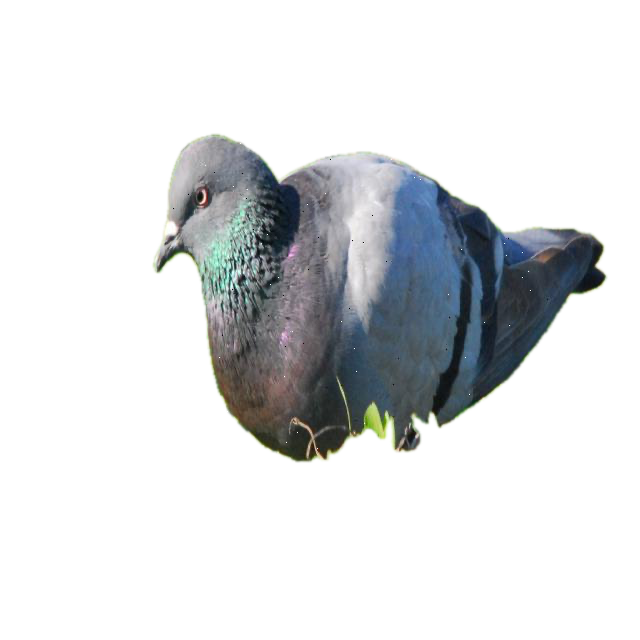

In [53]:
all_images_objects.images_dict["5b40ae2d62ce4e128ff1a8f97923ea2f_jpg"].get_cleaned_image()


In [50]:
all_images_objects.images_dict["5b40ae2d62ce4e128ff1a8f97923ea2f_jpg"].get_cropped_images(100)


ValueError: too many values to unpack (expected 5)

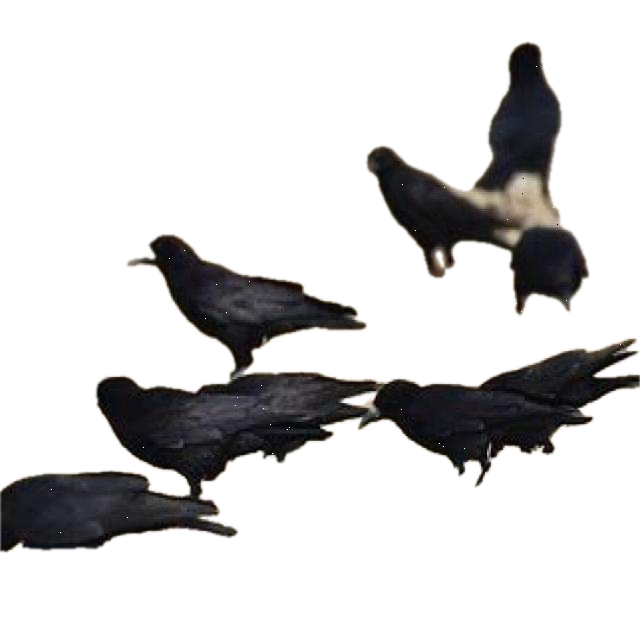

'0 0.25234375 0.2546875 0.271875 0.23125\n0 0.8203125 0.1921875 0.1546875 0.2859375\n0 0.684375 0.3296875 0.25 0.20625\n0 0.86484375 0.4203125 0.134375 0.134375\n0 0.7421875 0.6828125 0.36875 0.175\n0 0.39140625 0.471875 0.403125 0.2234375\n0 0.18671875 0.8328125 0.3734375 0.2\n0 0.26953125 0.69375 0.3359375 0.2078125'

In [236]:
all_images_objects.images_dict["crow-1246-_jpg"].get_cleaned_image()
all_images_objects.images_dict["crow-1246-_jpg"].label_text

In [238]:
'0 0.25234375 0.2546875 0.271875 0.23125'.split("\n")

['0 0.25234375 0.2546875 0.271875 0.23125']

In [222]:
all_images_objects.images_dict["20230517_122529_260_jpg"]

ImageData(image_name='20230517_122529_260_jpg', image_paths=['Harmful Birds Detection.v1i.yolov11/train/images/20230517_122529_260_jpg.rf.23280647819a5d87d5ce9a1374775c84.jpg', 'Harmful Birds Detection.v1i.yolov11/train/images/20230517_122529_260_jpg.rf.5574ce3ceb8094f34bc2757ad83b3649.jpg', 'Harmful Birds Detection.v1i.yolov11/train/images/20230517_122529_260_jpg.rf.50748684ba45a07b1add0907a44edd16.jpg'], label_text='0 0.2171875 0.29296875 0.07265625 0.11953125', bird_class=0, cleaned_file='')

In [159]:
from PIL import Image


In [ ]:
all_images_objects.get_random_picture((0,3))

1838


KeyError: 'Subject images crows/Subjects not pixelated/crows/images103_jpg.rf Background Removed.6f437ac598fecfa0424ed6a2611c13ab.png'

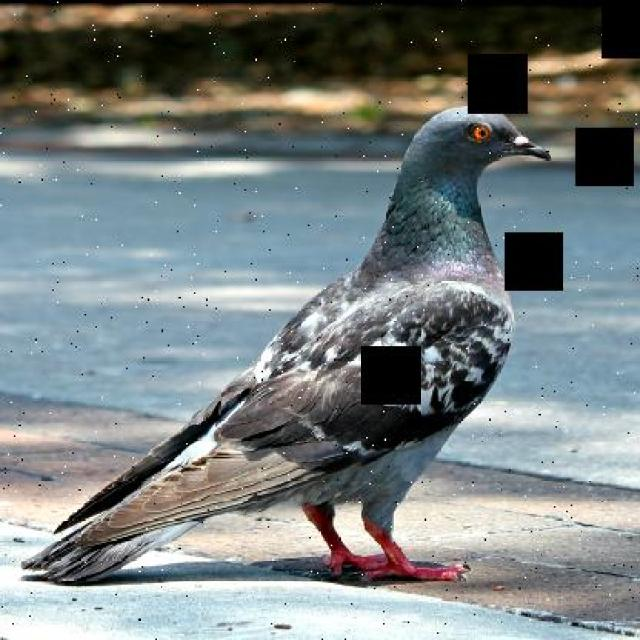

'Harmful Birds Detection.v1i.yolov11/test/images/da7a89cf1374497e91438d8e50214e3e_jpg.rf.9ef6c6dc45fe2e7205f87fdbcc2d94cc.jpg'

In [215]:
image_object.get_random_picture((3,))

Opencv to add the pictures to the pictures